# MVP — Machine Learning & Analytics

**Autor:** LEANDRO PORTELA DA LUZ  

**Data:** 28/09/2025

**Disciplina:** Ciência de Dados e Analitics

**Matrícula:** 20250_01

## 📘 Resumo Executivo

Este MVP aborda o problema da **previsão de consumo horário de energia elétrica em residências**, utilizando o dataset público *Individual Household Electric Power Consumption* (UCI Machine Learning Repository, 2006–2010).  

A solução foi desenvolvida em etapas organizadas e transparentes, seguindo boas práticas de ciência de dados: **preparo da base**, **engenharia de atributos** (lags, médias móveis, harmônicos, calendário), **divisão temporal justa** (treino, validação e teste, sem vazamento de informação) e **modelagem comparativa**.  

Foram testados diferentes modelos progressivos:  
- **Naïve (persistência)** como referência mínima,  
- **Regressão Linear (Ridge)**,  
- **Random Forest**,  
- **HistGradientBoosting** (versão padrão e tunada).  

🔎 **Resultado final**: o modelo **HGB Tunado** apresentou o melhor equilíbrio entre erro e capacidade explicativa, alcançando **R² ≈ 0,61** e reduções consistentes em MAE/RMSE. Isso confirma que a engenharia de atributos foi eficaz e que modelos de boosting são mais adequados para capturar os padrões de consumo da série.  

✅ O trabalho demonstra que, mesmo em um problema desafiador, é possível construir uma solução robusta e reprodutível, que serve como referência para análises futuras e evoluções com variáveis externas ou técnicas avançadas de aprendizado sequencial.  



## 1. Bibliotecas e Configurações

Nesta seção são definidos os pacotes utilizados no projeto e os parâmetros de configuração
para garantir **reprodutibilidade** e **padronização** dos resultados.

- **Imports**: carregamos apenas bibliotecas essenciais para manipulação de dados,
  visualização e modelagem (NumPy, Pandas, Matplotlib, scikit-learn).
- **Reprodutibilidade**: fixamos uma semente aleatória (`SEED = 42`) para assegurar que os
  resultados possam ser reproduzidos em diferentes execuções.
- **Estilo / Logs**: configuramos opções de exibição do Pandas e estilo dos gráficos do Matplotlib,
  além de registrar as versões das principais bibliotecas utilizadas.


### 1.1. Imports

In [1]:
# === Célula 1: Imports (enxutos) ===
import os, io, zipfile, sys, gc, requests, math, time, random, warnings, json, joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelagem & Validação
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 1.2. Reprodutibilidade

In [2]:
# Reprodutibilidade
SEED = 42

# Fixar aleatoriedade do Python e libs comuns
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)

### 1.3. Estilo/ Logs

In [3]:
# Estilo / Logs (versões + ambiente)
import sys, warnings, os, platform, shutil, subprocess
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")  # reduz ruído visual
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

# Versões principais
print("Python :", sys.version.split()[0])
print("Pandas :", pd.__version__)
try:
    import sklearn
    print("sklearn:", sklearn.__version__)
except Exception:
    pass

# Ambiente (OS/CPU/RAM/GPU)
print("OS   :", platform.platform())
print("CPUs :", os.cpu_count())

# RAM (psutil é opcional; se não existir, só ignora)
try:
    import psutil
    ram_gb = psutil.virtual_memory().total / 1e9
    print("RAM  :", f"{ram_gb:.2f} GB")
except Exception:
    pass

# GPU (se houver no runtime do Colab)
try:
    if shutil.which("nvidia-smi"):
        info = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name,memory.total", "--format=csv,noheader"]
        ).decode().strip()
        print("GPU  :", info)
    else:
        print("GPU  : None")
except Exception:
    print("GPU  : (erro ao consultar)")

# Consistência visual dos gráficos
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["figure.dpi"] = 110

Python : 3.12.11
Pandas : 2.2.2
sklearn: 1.6.1
OS   : Linux-6.6.97+-x86_64-with-glibc2.35
CPUs : 2
RAM  : 13.61 GB
GPU  : None


## 2. Funções Auxiliares

Nesta seção definimos funções de apoio que serão utilizadas ao longo do projeto para avaliar os modelos de forma consistente.

- **RMSE (`rmse_fn`)**: cálculo robusto da raiz do erro quadrático médio, compatível com diferentes versões do scikit-learn.  
- **MAPE seguro (`mape_safe`)**: cálculo do erro percentual médio absoluto, adaptado para evitar divisões por zero (ex.: adicionando `ε=1e-6` ao denominador), garantindo resultados estáveis.  
- **Avaliação padronizada (`avalia`)**: imprime de forma clara as principais métricas de desempenho (MAE, RMSE, MAPE e R²), facilitando a comparação entre diferentes modelos.  
- **Medição de tempos (`medir_tempos`)**: registra os tempos de treino (*fit*) e de previsão (*predict*) de um modelo, permitindo analisar não apenas a acurácia, mas também o custo computacional de cada baseline.


### 2.1. RMSE

In [4]:
# Função RMSE (compatível com qualquer versão sklearn)
try:
    from sklearn.metrics import root_mean_squared_error as _rmse_native
    def rmse_fn(y_true, y_pred):
        """Calcula RMSE usando função nativa (sklearn >= 1.3)."""
        return float(_rmse_native(y_true, y_pred))
except Exception:
    from sklearn.metrics import mean_squared_error
    import numpy as np
    def rmse_fn(y_true, y_pred):
        """Calcula RMSE sem usar 'squared', para compatibilidade ampla."""
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

### 2.2. MAPE

In [5]:
# Função MAPE seguro
def mape_safe(y_true, y_pred):
    """
    Calcula MAPE (%) evitando divisões por zero e valores infinitos.
    Retorna o erro percentual médio absoluto em %.
    """
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred, index=y_true.index)
    m = (np.abs((y_true - y_pred) / y_true)
         .replace([np.inf, -np.inf], np.nan)
         .dropna())
    return float(m.mean() * 100) if len(m) else np.nan

### 2.3. Avaliação padronizada

In [6]:
# Função de avaliação padronizada
def avalia(y_true, y_pred, nome=""):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = rmse_fn(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape = mape_safe(y_true, y_pred)  # usa versão robusta
    print(f"{nome} | MAE={mae:.4f}  RMSE={rmse:.4f}  MAPE={mape:.2f}%  R²={r2:.4f}")

### 2.4. Medição de tempo (treino e predição)

Para comparar os modelos de forma justa, vamos medir também o **tempo de treino (fit)** e de **predição (predict)**.
As métricas serão calculadas pelas **mesmas funções padronizadas** usadas no projeto (`rmse_fn`, `mape_safe`), garantindo consistência.



In [7]:
# Medição de tempo

def medir_tempos(model, Xtr, ytr, Xva, yva, Xte, yte, nome=""):
    """
    Treina o modelo e mede tempo de fit/predict.
    Calcula métricas de Val/Test usando as funções padronizadas rmse_fn e mape_safe.
    Retorna: (dict com métricas + tempos, y_va_pred, y_te_pred)
    """
    # Treino
    t0 = time.perf_counter()
    model.fit(Xtr, ytr)
    fit_s = time.perf_counter() - t0

    # Predição (Validação)
    t0 = time.perf_counter()
    y_va_pred = model.predict(Xva)
    pred_s_val = time.perf_counter() - t0

    # Predição (Teste)
    t0 = time.perf_counter()
    y_te_pred = model.predict(Xte)
    pred_s_te = time.perf_counter() - t0

    # Métricas padronizadas (consistentes com 2.1/2.2/2.3)
    mae_val  = mean_absolute_error(yva, y_va_pred)
    rmse_val = rmse_fn(yva, y_va_pred)
    mape_val = mape_safe(yva, y_va_pred)
    r2_val   = r2_score(yva, y_va_pred)

    mae_te  = mean_absolute_error(yte, y_te_pred)
    rmse_te = rmse_fn(yte, y_te_pred)
    mape_te = mape_safe(yte, y_te_pred)
    r2_te   = r2_score(yte, y_te_pred)

    res = {
        "modelo": nome,
        "MAE_val": float(mae_val),
        "RMSE_val": float(rmse_val),
        "MAPE_val": float(mape_val),
        "R2_val": float(r2_val),
        "MAE_test": float(mae_te),
        "RMSE_test": float(rmse_te),
        "MAPE_test": float(mape_te),
        "R2_test": float(r2_te),
        "fit_s": float(fit_s),
        "pred_s": float(pred_s_val + pred_s_te)
    }
    return res, y_va_pred, y_te_pred

## 3. Engenharia de Dados

Nesta etapa preparamos o dataset bruto para uso em modelagem preditiva, aplicando técnicas de **carregamento, conversão, diagnóstico de qualidade e tratamento de valores ausentes**.  

As principais ações incluíram:  
- Carregamento da base original e padronização da coluna temporal (`datetime`).  
- Conversão de variáveis elétricas para valores numéricos válidos.  
- Diagnóstico de lacunas e inconsistências na série temporal (minuto a minuto).  
- Identificação e tratamento de registros ausentes, com política diferenciada para o alvo (`Global_active_power`) e para as variáveis explicativas.  
- Verificação de faixas plausíveis para cada variável, assegurando consistência física dos dados.  

**Resultado:** obtivemos um dataset limpo, íntegro e confiável (`df_limpo`), pronto para as etapas de agregação, análise e modelagem.


### 3.1. Carregamento Dados

- **Fonte oficial**: UCI ML Repository — *Individual household electric power consumption*.  
- **URL oficial do ZIP**: <https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip>  
  - Dentro do ZIP, o arquivo principal é `household_power_consumption.txt` (separador `;` e decimal `.`).  
- **Fonte prática usada no notebook**: para facilitar a execução no Colab, o mesmo arquivo `.zip` é carregado a partir de um repositório público no GitHub.  
  - O conteúdo é idêntico ao dataset oficial, preservando a forma bruta (sem tratamento prévio).  


#### 3.1.1. Carregando dataset

- **Download** do ZIP via `requests.get(...)` e **leitura direta** do arquivo `household_power_consumption.txt` dentro do ZIP com `zipfile.ZipFile(...).open(...)`.  
- **Leitura com `pd.read_csv`** usando:
  - `sep=";"` (separador oficial do arquivo),
  - `na_values=["?", "NA", "NaN", ""]` (marcações de ausentes),
  - `dtype=str` (tudo como *string* por enquanto, para conversão controlada no passo 3.2),
  - `low_memory=False` (evita *guessing* de tipos por chunks).  
- **Padronização de nomes de colunas**: `df_bruto.columns = [c.strip() for c in df_bruto.columns]` (remove espaços invisíveis).  
- Tempo de execução exibido pelo `%%time` (pode variar conforme ambiente).

In [8]:
%%time
# local do dataset
DATASET_ZIP_URL = "https://raw.githubusercontent.com/ScienceLeo/mvp-sprint3-ml/main/data/household_power_consumption.zip"
FILE_INSIDE_ZIP = "household_power_consumption.txt"

# Download + Leitura do dataset
r = requests.get(DATASET_ZIP_URL, timeout=60)
r.raise_for_status()  # falha cedo se a URL cair

z = zipfile.ZipFile(io.BytesIO(r.content))
df_bruto = pd.read_csv(
    z.open(FILE_INSIDE_ZIP),
    sep=";",
    na_values=["?", "NA", "NaN", ""],
    dtype=str,            # ler tudo como string (converteremos depois)
    low_memory=False
)

# padroniza nomes (evita espaços invisíveis)
df_bruto.columns = [c.strip() for c in df_bruto.columns]

CPU times: user 4 s, sys: 744 ms, total: 4.75 s
Wall time: 5.76 s


#### 3.1.2. Visualizações dataset

- **`head()`**: visualização das primeiras linhas confirma estrutura esperada (colunas originais `Date`, `Time` e variáveis elétricas).  
- **`shape`**: `(2075259, 9)` — 2.075.259 linhas e 9 colunas (granularidade minuto a minuto).  
- **`info()`**: todas as colunas estão como `object` (string) **por decisão intencional**, para realizarmos a **conversão numérica controlada** no item 3.2.  
- Próximo passo (3.2): conversão de tipos numéricos com coerção de valores inválidos.



In [9]:
# permite visualizar as primeiras linhas do dataset para verificar a estrutura inicial.
df_bruto.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


In [10]:
# retorna as dimensões do DataFrame (número de linhas e colunas).
df_bruto.shape

(2075259, 9)

In [11]:
# apresenta os tipos de dados de cada coluna, quantidade de valores não nulos e o uso de memória.
df_bruto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB


### 3.2. Conversão e Pré-processamento  

Nesta etapa realizamos a preparação da base, garantindo qualidade e consistência dos dados antes da agregação e modelagem:  

- **Conversão inicial**: criamos a coluna `datetime` a partir de `Date` + `Time`, excluímos registros inválidos e convertemos as variáveis elétricas para valores numéricos, registrando os casos inválidos como `NaN`.  
- **Diagnóstico temporal**: verificamos a sequência minuto a minuto, confirmando que não havia lacunas de registros na linha do tempo.  
- **Flags de qualidade**: identificamos blocos consecutivos de valores ausentes e medimos seu impacto global (1,25% dos registros).  
- **Tratamento de ausentes**: aplicamos política diferenciada:  
  - No **alvo** (`Global_active_power`), blocos longos (>60 min) foram removidos; faltas curtas e médias foram preenchidas com *forward fill* ou interpolação temporal.  
  - Nas **variáveis explicativas**, aplicamos *forward fill* e interpolação mesmo em blocos longos, preservando janelas extensas de dados.  
  - Colunas auxiliares de auditoria foram descartadas após o tratamento.  
- **Checagem de faixas plausíveis**: confirmamos que todos os valores estão dentro dos limites físicos esperados para potência, tensão, corrente e submedições.  

**Resultado:** obtivemos um dataset íntegro e consistente, sem perdas desnecessárias de registros, pronto para a etapa de agregação e modelagem.

Observação:

**Convenção de datasets adotada**  
 - `df_bruto`: dataset bruto carregado do ZIP, sem transformações.  
 - `df`: dataset em análise, após parsing, tipagem e diagnósticos (minuto a minuto).  
 - `df_limpo`: dataset final, gerado no item 4.4 após tratamento de valores ausentes, pronto para agregação e modelagem.  

 → Apenas o dataset validado e consistente (`df_limpo`) será utilizado nas próximas etapas.


#### 3.2.1 Conversão e Tipagem de Dados

Nesta etapa:

- Criamos a coluna `datetime` a partir de `Date` + `Time` e removemos registros inválidos (nenhuma linha foi excluída).  
- Convertimos as variáveis elétricas para formato numérico, sem geração de novos valores ausentes.  
- Excluímos as colunas originais `Date` e `Time`, reorganizando a tabela para iniciar por `datetime`.  
- Intervalo temporal resultante: **16/12/2006 a 26/11/2010**.  



In [12]:
# Criando uma cópia do dataset df_bruto para df
df = df_bruto.copy()

In [13]:
%%time
# Conversão e Tipagem de Dados

NUM_COLS = [
    "Global_active_power", "Global_reactive_power", "Voltage",
    "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]

# 1) cria datetime
df["datetime"] = pd.to_datetime(
    df["Date"].str.strip() + " " + df["Time"].str.strip(),
    format="%d/%m/%Y %H:%M:%S", dayfirst=True, errors="coerce"
)

# 2) remove linhas inválidas de datetime
before = len(df)
df = df.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)
after = len(df)
print(f"Linhas removidas por datetime inválido: {before - after}")

# 3) converte colunas numéricas
invalid_counts = {}
for c in NUM_COLS:
    before_nulls = df[c].isna().sum()
    df[c] = pd.to_numeric(df[c], errors="coerce")
    after_nulls = df[c].isna().sum()
    invalid_counts[c] = after_nulls - before_nulls

# 4) elimina redundância (Date, Time) e reorganiza
df = df.drop(columns=["Date", "Time"])
df = df[["datetime"] + [c for c in df.columns if c != "datetime"]]

# 5) relatório
print("Intervalo temporal:", df["datetime"].min(), "→", df["datetime"].max())
print("Valores inválidos (convertidos para NaN) por coluna:")
print(pd.Series(invalid_counts).sort_values(ascending=False))

df.head(5)

Linhas removidas por datetime inválido: 0
Intervalo temporal: 2006-12-16 17:24:00 → 2010-11-26 21:02:00
Valores inválidos (convertidos para NaN) por coluna:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
CPU times: user 23.5 s, sys: 1.01 s, total: 24.5 s
Wall time: 36.7 s


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


#### 3.2.2 Diagnóstico de Frequëncia e Lacunas

Nesta etapa verificamos se a série temporal possui registros contínuos minuto a minuto, como esperado no dataset:

- Calculamos os intervalos de tempo entre registros consecutivos (`gap_min`) para identificar possíveis falhas.  
- Classificamos as lacunas em **curtas** (≤3 min), **médias** (≤60 min) e **longas** (>60 min), facilitando decisões de tratamento.  
- Conferimos o total de linhas esperadas no intervalo temporal e comparamos com o total real do dataset.  

**Resultado:** não foram encontradas lacunas temporais; o número de registros minuto a minuto está completo e consistente.  
A coluna auxiliar `gap_min`, criada apenas para verificação, foi removida após a checagem para otimizar memória.

In [14]:
%%time
# Diagnóstico de frequência e lacunas
df = df.sort_values("datetime").reset_index(drop=True)
df["gap_min"] = df["datetime"].diff().dt.total_seconds().div(60)

lacunas = df.loc[df["gap_min"] > 1, ["datetime", "gap_min"]].copy()

def classificar_gap(x):
    if x <= 3: return "curta"
    if x <= 60: return "media"
    return "longa"

lacunas["tipo"] = lacunas["gap_min"].apply(classificar_gap)

print("Resumo lacunas (min):")
print(lacunas.groupby("tipo")["gap_min"].agg(["count", "sum"]))

# Expectativa de linhas (minuto a minuto)
dt_min, dt_max = df["datetime"].min(), df["datetime"].max()
full_idx = pd.date_range(dt_min, dt_max, freq="min")
print("Esperado (minutos consecutivos):", len(full_idx), "| Temos:", len(df))

Resumo lacunas (min):
Empty DataFrame
Columns: [count, sum]
Index: []
Esperado (minutos consecutivos): 2075259 | Temos: 2075259
CPU times: user 370 ms, sys: 193 ms, total: 563 ms
Wall time: 599 ms


In [15]:
%%time
# Limpeza da coluna auxiliar
if "gap_min" in df.columns:
    df = df.drop(columns=["gap_min"])
    print("Coluna 'gap_min' removida. Shape atual:", df.shape)

df.head()

Coluna 'gap_min' removida. Shape atual: (2075259, 8)
CPU times: user 31.8 ms, sys: 33.5 ms, total: 65.3 ms
Wall time: 77.7 ms


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


#### 3.2.3 Flags de Qualidade

Nesta etapa auditamos a base para identificar falhas nas **variáveis elétricas** (mesmo sem lacunas na linha do tempo).   
Para cada linha, marcamos se existe ao menos um valor ausente (`is_nan`) e agrupamos **sequências consecutivas** de falhas (`nan_block_id`).

Em seguida, resumimos os **maiores blocos** (início/fim, duração em minutos/horas/dias) e o **impacto total** no dataset.

**Resultado:** foram identificados blocos longos de falhas (~5 dias e ~3,6 dias), totalizando cerca de **1,25%** das linhas do dataset. Esses períodos refletem indisponibilidade dos sensores e serão tratados de forma diferenciada na etapa seguinte.

Esses blocos indicam períodos de indisponibilidade do sensor. Essa auditoria orienta a política de tratamento adotada na próxima etapa.


In [16]:
%%time
# Flags de qualidade
df["is_nan"] = df[NUM_COLS].isna().any(axis=1)
df["nan_block_id"] = (df["is_nan"] != df["is_nan"].shift()).cumsum()

nan_blocks = (df.groupby(["nan_block_id","is_nan"])
                .size()
                .reset_index(name="length"))
nan_blocks = nan_blocks[nan_blocks["is_nan"]].sort_values("length", ascending=False)

print("Top 5 blocos de NaN consecutivos:")
nan_blocks.head(5)

Top 5 blocos de NaN consecutivos:
CPU times: user 319 ms, sys: 46.1 ms, total: 365 ms
Wall time: 397 ms


,nan_block_id,is_nan,length
137,138,True,7226
139,140,True,5237
13,14,True,3723
99,100,True,3305
117,118,True,3129


In [17]:
%%time
# Garantir ordem
df = df.sort_values("datetime").reset_index(drop=True)

# Já temos is_nan e nan_block_id das células anteriores.
# Construir um resumo rico por bloco:
resumo_blocos = (
    df.assign(idx=np.arange(len(df)))
      .groupby(["nan_block_id","is_nan"])
      .agg(
          length=("idx","size"),
          t_ini=("datetime","min"),
          t_fim=("datetime","max")
      )
      .reset_index()
      .query("is_nan == True")
      .sort_values("length", ascending=False)
)

# métricas globais
total_linhas = len(df)
resumo_blocos["minutos"] = resumo_blocos["length"]
resumo_blocos["horas"]   = (resumo_blocos["length"]/60).round(2)
resumo_blocos["dias"]    = (resumo_blocos["length"]/1440).round(2)
resumo_blocos["pct_dataset"] = (100*resumo_blocos["length"]/total_linhas).round(3)

print(f"Total linhas: {total_linhas}")
print("Top 5 blocos com falhas consecutivas:")
display(resumo_blocos.head(5)[["nan_block_id","t_ini","t_fim","minutos","horas","dias","pct_dataset"]])

print("\nImpacto total (todas as falhas):")
impacto_total = resumo_blocos["length"].sum()
print(f"- Linhas com falha: {impacto_total}  ({100*impacto_total/total_linhas:.3f}%)")

Total linhas: 2075259
Top 5 blocos com falhas consecutivas:


,nan_block_id,t_ini,t_fim,minutos,horas,dias,pct_dataset
137,138,2010-08-17 21:02:00,2010-08-22 21:27:00,7226,120.43,5.02,0.348
139,140,2010-09-25 03:56:00,2010-09-28 19:12:00,5237,87.28,3.64,0.252
13,14,2007-04-28 00:21:00,2007-04-30 14:23:00,3723,62.05,2.59,0.179
99,100,2009-06-13 00:30:00,2009-06-15 07:34:00,3305,55.08,2.30,0.159
117,118,2010-01-12 14:53:00,2010-01-14 19:01:00,3129,52.15,2.17,0.151



Impacto total (todas as falhas):
- Linhas com falha: 25979  (1.252%)
CPU times: user 383 ms, sys: 138 ms, total: 520 ms
Wall time: 523 ms


In [18]:
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_nan,nan_block_id
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,False,1
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,False,1
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,False,1
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,False,1
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,False,1


#### 3.2.4 Tratamento de Valores Ausentes  

Nesta etapa adotamos uma política diferenciada para lidar com registros faltantes, priorizando a preservação da variável alvo e garantindo consistência nas variáveis explicativas:  

- **Variável alvo (`Global_active_power`)**:  
  - Removemos blocos longos de ausência (superiores a 60 minutos), evitando a criação de consumos artificiais.  
  - Para ausências curtas (≤3 minutos) aplicamos preenchimento pelo valor imediatamente anterior (*forward fill*).  
  - Para ausências médias (≤60 minutos) aplicamos interpolação temporal.

- **Variáveis explicativas (tensão, corrente e submedições)**:  
  - Aplicamos preenchimento (*forward fill*) e interpolação mesmo em blocos longos, de forma a preservar janelas extensas de dados sempre que a variável alvo permanecia válida.  

- **Colunas auxiliares (`is_nan`, `nan_block_id`)**:  
  - Após o diagnóstico e tratamento, foram removidas para liberar memória e evitar conflitos nas etapas seguintes.  

**Resultado:** o alvo de previsão foi mantido íntegro, com remoção apenas de blocos longos sem medição.  
As variáveis explicativas foram suavizadas por preenchimento e interpolação, assegurando um dataset final consistente.  
As colunas auxiliares usadas para auditoria foram descartadas.

In [19]:
%%time
# Tratamento dos valores ausentes — política mista orientada ao ALVO

# --- Definições ---
TARGET = "Global_active_power"
FEAT_COLS = [c for c in NUM_COLS if c != TARGET]

# Garantir ordenação temporal
df = df.sort_values("datetime").reset_index(drop=True)

# 1) Identificar blocos consecutivos de NaN no ALVO
mask_target_nan = df[TARGET].isna()
target_block_id = (mask_target_nan != mask_target_nan.shift()).cumsum()

# tamanho de cada bloco (apenas onde há NaN no alvo)
tmp = (
    pd.DataFrame({"block": target_block_id, "is_nan": mask_target_nan})
      .groupby(["block", "is_nan"])
      .size()
      .reset_index(name="length")
)
# mapa: id_do_bloco -> comprimento
len_map = dict(zip(tmp["block"], tmp["length"]))
df["target_block_len"] = target_block_id.map(len_map)

# 2) Remover APENAS blocos longos (>60 min) onde o ALVO falta
mask_longas_target = mask_target_nan & (df["target_block_len"] > 60)

before = len(df)
df_limpo = df.loc[~mask_longas_target].copy()
removed_long_target = before - len(df_limpo)
print(f"Removidas {removed_long_target} linhas por blocos longos (>60 min) de NaN no ALVO.")

# 3) Setar índice temporal para operações por tempo
df_limpo = df_limpo.set_index("datetime").sort_index()

# 4) Tratar faltas restantes
#    4.1 ALVO: ffill (≤3) + interpolação temporal (≤60) — após a remoção dos blocos longos
df_limpo[TARGET] = df_limpo[TARGET].fillna(method="ffill", limit=3)
df_limpo[TARGET] = df_limpo[TARGET].interpolate(method="time", limit=60)

#    4.2 FEATURES: ffill (≤3) + interpolação temporal (SEM limite)
for c in FEAT_COLS:
    df_limpo[c] = df_limpo[c].fillna(method="ffill", limit=3)
    # sem 'limit' para aceitar interpolação mesmo em blocos longos (apenas features)
    df_limpo[c] = df_limpo[c].interpolate(method="time")

# 5) Quaisquer NaN remanescentes (raros) -> remover
rest_before = len(df_limpo)
df_limpo = df_limpo.dropna(subset=[TARGET] + FEAT_COLS)
rest_removed = rest_before - len(df_limpo)
print(f"Removidas {rest_removed} linhas restantes com NaN após tratamento.")

# 6) Limpeza de colunas auxiliares e volta 'datetime' como coluna
df_limpo = df_limpo.drop(columns=[c for c in ["target_block_len"] if c in df_limpo.columns], errors="ignore")
df_limpo = df_limpo.reset_index()

print("Dataset pronto para agregação horária:", df_limpo.shape)
df_limpo.head(5)

Removidas 25691 linhas por blocos longos (>60 min) de NaN no ALVO.
Removidas 0 linhas restantes com NaN após tratamento.
Dataset pronto para agregação horária: (2049568, 10)
CPU times: user 2.32 s, sys: 527 ms, total: 2.84 s
Wall time: 2.9 s


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_nan,nan_block_id
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,False,1
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,False,1
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,False,1
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,False,1
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,False,1


In [20]:
# Remove colunas auxiliares, se existirem
df_limpo = df_limpo.drop(columns=["is_nan","nan_block_id"], errors="ignore")

print("Dataset final de limpeza:", df_limpo.shape)
df_limpo.head(5)

Dataset final de limpeza: (2049568, 8)


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


#### 3.2.5 Checagem de faixas plausíveis

Verificamos se as variáveis elétricas permanecem dentro de limites físicos conservadores
(potência ativa 0–12 kW, reativa 0–5 kVAr, tensão 180–260 V, corrente 0–60 A e submedições 0–5000 Wh/min).   
**Resultado:** nenhuma ocorrência fora de faixa após o tratamento, indicando **Resultado:** todas as variáveis permaneceram dentro das faixas definidas; não foram encontradas ocorrências fora de limite, confirmando a consistência da base.

In [21]:
%%time
# checagem de faixas
checks = {
    "Global_active_power":  (0, 12),     # kW
    "Global_reactive_power":(0, 5),      # kVAr
    "Voltage":              (180, 260),  # V
    "Global_intensity":     (0, 60),     # A
    "Sub_metering_1":       (0, 5000),   # Wh/min
    "Sub_metering_2":       (0, 5000),
    "Sub_metering_3":       (0, 5000),
}
viol = {}
for col, (lo, hi) in checks.items():
    viol[col] = (~df_limpo[col].between(lo, hi)).sum()
print("Fora de faixa (por coluna):")
print(pd.Series(viol).sort_values(ascending=False))
df_limpo.head()

Fora de faixa (por coluna):
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
CPU times: user 154 ms, sys: 3.93 ms, total: 158 ms
Wall time: 119 ms


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


#### 3.2.6 Liberação de Memória

Após concluirmos a etapa de **Conversão e Pré-processamento**, apenas o dataset validado (`df_limpo`) será utilizado nas próximas análises e modelagens.  
Para otimizar o uso de recursos e liberar memória, descartamos os datasets intermediários (`df_bruto` e `df`) que já cumpriram sua função nesta etapa.  

**Resultado:** apenas o dataset final `df_limpo` foi mantido para as próximas etapas, garantindo consistência e melhor aproveitamento da memória.

In [22]:
# Remove referências aos objetos
del df_bruto, df

# Força o coletor de lixo a liberar a memória imediatamente
gc.collect()

64

## 4. Engenharia de Atributos

A engenharia de atributos transformou o dataset original em uma base enriquecida, capaz de capturar padrões de consumo de energia em diferentes horizontes temporais.  

As principais transformações aplicadas foram:  

- **Agregação horária**: criação do alvo físico (`y_kwh`), obtido a partir da soma da potência ativa minuto a minuto, normalizada para kWh/h, junto com médias horárias de variáveis elétricas e somatórios dos submeterings.  
- **Cobertura de dados**: cálculo da fração de minutos válidos por hora e aplicação de filtro para manter apenas registros com ≥ 90% de cobertura, garantindo consistência na série.  
- **Atributos de calendário e harmônicos**: inclusão de variáveis temporais (ano, mês, dia, dia da semana, hora, fim de semana) e suas representações cíclicas com seno e cosseno (hora, dia da semana e sazonalidade anual), preservando a natureza repetitiva do tempo.  
- **Lags da variável alvo**: criação de defasagens em múltiplos horizontes (1h até 168h/1 semana), fornecendo memória temporal ao modelo.  
- **Médias móveis causais (rollings)**: cálculo de médias históricas em janelas de 3h até 168h, capturando tendências e padrões suavizados do consumo.  
- **Consolidação final**: eliminação de valores ausentes após lags e rollings, organização dos grupos de atributos (originais, calendário, harmônicos, lags e rollings) e definição da base final de modelagem (`df_model`) com 33.983 registros e 35 colunas (1 alvo, 33 features e o identificador temporal).

**Resultado**: obtivemos uma base final estruturada, completa e sem valores ausentes, pronta para ser utilizada na modelagem e na divisão em conjuntos de treino, validação e teste.

#### 4.1 Agregação horária e criação do alvo `y_kwh`

Os dados minuto a minuto foram agregados em registros horários, gerando:

- **Alvo `y_kwh`**: consumo horário em kWh/h.  
- **Variáveis elétricas agregadas**:  
  - Médias: `GAP_mean`, `GRP_mean`, `Voltage_mean`, `Global_intensity_mean`  
  - Somatórios: `SM1_sum`, `SM2_sum`, `SM3_sum`  

Aplicamos também a métrica de **cobertura de dados por hora** e mantivemos apenas registros com ≥ 90% de completude.  

**Resultado:** dataset horário consolidado, consistente e pronto para enriquecimento com atributos temporais.

In [23]:
%%time
# Índice minuto-a-minuto completo, ancorado nas viradas de hora
base = df_limpo.set_index("datetime").sort_index()

start = base.index.min().floor("H")   # <— vira 17:00
end   = base.index.max().ceil("H")    # <— próxima virada da última hora
full_idx = pd.date_range(start, end, freq="T")

base_full = base.reindex(full_idx)  # insere NaN nos minutos inexistentes

# 2) Resample horário
g = base_full.resample("H")
hours_index = g["Global_active_power"].mean().index

# 3) Relógio: sempre 60 minutos por hora (porque index cobre a hora inteira)
clock = pd.Series(1, index=full_idx, name="one")
clock_h = clock.resample("H").sum().reindex(hours_index)   # deve ser 60 em horas completas

# 4) Agregações
df_hourly = pd.DataFrame({
    "datetime": hours_index,
    "y_kwh": g["Global_active_power"].sum() / 60.0,

    "GAP_mean": g["Global_active_power"].mean(),
    "GRP_mean": g["Global_reactive_power"].mean(),
    "Voltage_mean": g["Voltage"].mean(),
    "Global_intensity_mean": g["Global_intensity"].mean(),

    "SM1_sum": g["Sub_metering_1"].sum(),
    "SM2_sum": g["Sub_metering_2"].sum(),
    "SM3_sum": g["Sub_metering_3"].sum(),

    "n_valid": g["Global_active_power"].count(),   # minutos com valor
    "n_total": clock_h.values,                     # minutos esperados (tipicamente 60)
})

df_hourly["coverage"] = (df_hourly["n_valid"] / df_hourly["n_total"]).fillna(0.0)
df_hourly = df_hourly.reset_index(drop=True)
df_hourly.head(5)

CPU times: user 1.13 s, sys: 181 ms, total: 1.32 s
Wall time: 1.36 s


,datetime,y_kwh,GAP_mean,GRP_mean,Voltage_mean,Global_intensity_mean,SM1_sum,SM2_sum,SM3_sum,n_valid,n_total,coverage
0,2006-12-16 17:00:00,2.533733,4.222889,0.229000,234.643889,18.100000,0.0,19.0,607.0,36,60,0.6
1,2006-12-16 18:00:00,3.632200,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,60,60,1.0
2,2006-12-16 19:00:00,3.400233,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,60,60,1.0
3,2006-12-16 20:00:00,3.268567,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,60,60,1.0
4,2006-12-16 21:00:00,3.056467,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,60,60,1.0


In [24]:
# Quantas horas cairiam por limiar
tot = len(df_hourly)
thr_list = [0.80, 0.85, 0.90, 0.95, 0.98, 1.00]

print("Impacto por limiar de cobertura:")
for t in thr_list:
    keep = int((df_hourly["coverage"] >= t).sum())
    drop = tot - keep
    pct_drop = 100 * drop / tot
    print(f"  ≥ {int(t*100):>2d}%  → mantém {keep:5d}  descarta {drop:5d}  ({pct_drop:5.2f}%)")

Impacto por limiar de cobertura:
  ≥ 80%  → mantém 34156  descarta   434  ( 1.25%)
  ≥ 85%  → mantém 34153  descarta   437  ( 1.26%)
  ≥ 90%  → mantém 34151  descarta   439  ( 1.27%)
  ≥ 95%  → mantém 34150  descarta   440  ( 1.27%)
  ≥ 98%  → mantém 34149  descarta   441  ( 1.27%)
  ≥ 100%  → mantém 34149  descarta   441  ( 1.27%)


In [25]:
# Distribuição da cobertura
dist = (df_hourly["coverage"].round(2)
        .value_counts()
        .sort_index())
print(dist.head(10))   # ou dist.tail(10) / display(dist)

coverage
0.00    422
0.03      2
0.05      1
0.15      1
0.35      2
0.42      1
0.50      1
0.53      1
0.60      2
0.78      1
Name: count, dtype: int64


In [26]:
# Ver quais horas seriam afetadas
amostra_baixa = df_hourly[df_hourly["coverage"] < 0.90].head(10)
amostra_baixa[["datetime","coverage","n_valid","n_total","y_kwh"]]

,datetime,coverage,n_valid,n_total,y_kwh
0,2006-12-16 17:00:00,0.60,36,60,2.533733
3175,2007-04-28 00:00:00,0.35,21,60,0.378967
3176,2007-04-28 01:00:00,0.00,0,60,0.000000
3177,2007-04-28 02:00:00,0.00,0,60,0.000000
3178,2007-04-28 03:00:00,0.00,0,60,0.000000
3179,2007-04-28 04:00:00,0.00,0,60,0.000000
3180,2007-04-28 05:00:00,0.00,0,60,0.000000
3181,2007-04-28 06:00:00,0.00,0,60,0.000000
3182,2007-04-28 07:00:00,0.00,0,60,0.000000
3183,2007-04-28 08:00:00,0.00,0,60,0.000000


In [27]:
# aplicar o filtro coverage acima de 90 %
COVERAGE_MIN = 0.90
df_hourly = df_hourly[df_hourly["coverage"] >= COVERAGE_MIN].reset_index(drop=True)
print(f"Após filtro (≥{int(COVERAGE_MIN*100)}%):", df_hourly.shape)
df_hourly.head()

Após filtro (≥90%): (34151, 12)


,datetime,y_kwh,GAP_mean,GRP_mean,Voltage_mean,Global_intensity_mean,SM1_sum,SM2_sum,SM3_sum,n_valid,n_total,coverage
0,2006-12-16 18:00:00,3.632200,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,60,60,1.0
1,2006-12-16 19:00:00,3.400233,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,60,60,1.0
2,2006-12-16 20:00:00,3.268567,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,60,60,1.0
3,2006-12-16 21:00:00,3.056467,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,60,60,1.0
4,2006-12-16 22:00:00,2.200133,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0,60,60,1.0


##### 4.1.1 Sanidade e Resumo Rápido

Após a agregação horária, verificamos a consistência do dataset:

- `datetime` está ordenado.  
- O alvo `y_kwh` apresentou média de ~1,09 kWh/h, com valores plausíveis.  
- Não há valores nulos em colunas-chave (`y_kwh`, `GAP_mean`, `Voltage_mean`, `coverage`).  

**Resultado:** dataset horário validado e pronto para as próximas etapas de engenharia de atributos.

In [28]:
%%time
# Sanidade e resumo rápido

# Verifica se o datetime está ordenado
assert df_hourly["datetime"].is_monotonic_increasing, "datetime não está ordenado!"

# Estatísticas descritivas do alvo
print("Resumo alvo y_kwh (kWh por hora):")
display(df_hourly["y_kwh"].describe(percentiles=[.1, .5, .9, .99]).to_frame().T)

# Checagem de nulos nas colunas principais
print("\nChecagem de nulos nas colunas-chave:")
print(df_hourly[["y_kwh","GAP_mean","Voltage_mean","coverage"]].isna().sum())


Resumo alvo y_kwh (kWh por hora):


,count,mean,std,min,10%,50%,90%,99%,max
y_kwh,34151.0,1.091565,0.897543,0.124,0.274567,0.8028,2.345133,3.926683,6.560533



Checagem de nulos nas colunas-chave:
y_kwh           0
GAP_mean        0
Voltage_mean    0
coverage        0
dtype: int64
CPU times: user 35 ms, sys: 955 µs, total: 36 ms
Wall time: 36.5 ms


#### 4.2 Calendário  

Foram criados atributos de calendário a partir da coluna temporal (`datetime`), permitindo capturar padrões sazonais do consumo elétrico em diferentes escalas de tempo:  

- **year, month, day**: componentes básicos de data para variações sazonais anuais e mensais.  
- **dow (day of week)**: dia da semana (0 = segunda, ..., 6 = domingo).  
- **hour**: hora do dia (0–23), essencial para capturar ciclos diários.  
- **is_weekend**: indicador binário (0/1) para finais de semana, refletindo diferenças no perfil de consumo residencial.  

**Resultado:** incluido informações temporais estruturadas, enriquecendo a base com variáveis que ajudam a modelar padrões de consumo associados a dias, semanas e meses.  


In [29]:
%%time
# Atributos de calendário (idempotente e sem vazamento)

# Garante datetime no tipo correto e ordem temporal
df_hourly["datetime"] = pd.to_datetime(df_hourly["datetime"], errors="coerce")
df_hourly = df_hourly.sort_values("datetime").reset_index(drop=True)

# Calendário básico
df_hourly["year"]       = df_hourly["datetime"].dt.year
df_hourly["month"]      = df_hourly["datetime"].dt.month
df_hourly["day"]        = df_hourly["datetime"].dt.day
df_hourly["dow"]        = df_hourly["datetime"].dt.weekday   # 0=Seg, 6=Dom
df_hourly["hour"]       = df_hourly["datetime"].dt.hour
df_hourly["is_weekend"] = (df_hourly["dow"] >= 5).astype(int)

# (Opcional) Semana ISO — útil para análises sazonais semanais
# df_hourly["week"] = df_hourly["datetime"].dt.isocalendar().week.astype(int)

created = ["year","month","day","dow","hour","is_weekend"]  # + ["week"] se habilitar acima
print("Atributos de calendário criados:", created)
print("df_hourly:", df_hourly.shape)
df_hourly.head(5)

Atributos de calendário criados: ['year', 'month', 'day', 'dow', 'hour', 'is_weekend']
df_hourly: (34151, 18)
CPU times: user 27.5 ms, sys: 1.12 ms, total: 28.7 ms
Wall time: 28.5 ms


,datetime,y_kwh,GAP_mean,GRP_mean,Voltage_mean,Global_intensity_mean,SM1_sum,SM2_sum,SM3_sum,n_valid,n_total,coverage,year,month,day,dow,hour,is_weekend
0,2006-12-16 18:00:00,3.632200,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,60,60,1.0,2006,12,16,5,18,1
1,2006-12-16 19:00:00,3.400233,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,60,60,1.0,2006,12,16,5,19,1
2,2006-12-16 20:00:00,3.268567,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,60,60,1.0,2006,12,16,5,20,1
3,2006-12-16 21:00:00,3.056467,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,60,60,1.0,2006,12,16,5,21,1
4,2006-12-16 22:00:00,2.200133,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0,60,60,1.0,2006,12,16,5,22,1


#### 4.3. Harmônicos (variáveis cíclicas)

Nesta etapa criamos variáveis senoidais e cossenoidais para representar ciclos temporais de forma contínua, evitando descontinuidades artificiais nos limites dos períodos (por exemplo, hora 23 próxima da hora 0):

- **Ciclo diário (24h):** `sin_hour`, `cos_hour`  
- **Ciclo semanal (7 dias):** `sin_dow`, `cos_dow`  
- **Ciclo anual (365 dias, opcional):** `sin_year`, `cos_year`

Essas transformações permitem que modelos de machine learning capturem padrões sazonais de forma suave, sem tratar os limites como pontos distantes.  

**Resultado:** o dataset passa a conter representações cíclicas de hora, dia-da-semana e sazonalidade anual, enriquecendo a engenharia de atributos para capturar efeitos de calendário no consumo.


In [30]:
%%time
#  Harmônicos (variáveis cíclicas) para hora, dia-da-semana e (opcional) ano

# Garante datetime consistente
df_hourly["datetime"] = pd.to_datetime(df_hourly["datetime"], errors="coerce")
df_hourly = df_hourly.sort_values("datetime").reset_index(drop=True)

# Bases já criadas no passo de calendário:
# - hour (0..23), dow (0..6). Se não existirem (execução isolada), crie-as.
if "hour" not in df_hourly.columns:
    df_hourly["hour"] = df_hourly["datetime"].dt.hour
if "dow" not in df_hourly.columns:
    df_hourly["dow"] = df_hourly["datetime"].dt.weekday

# 1) Ciclo diário (24 horas)
df_hourly["sin_hour"] = np.sin(2 * np.pi * df_hourly["hour"] / 24.0)
df_hourly["cos_hour"] = np.cos(2 * np.pi * df_hourly["hour"] / 24.0)

# 2) Ciclo semanal (7 dias)
df_hourly["sin_dow"] = np.sin(2 * np.pi * df_hourly["dow"] / 7.0)
df_hourly["cos_dow"] = np.cos(2 * np.pi * df_hourly["dow"] / 7.0)

# 3) (Opcional) Ciclo anual pelo dia do ano (1..365/366)
ADD_YEARLY = True  # altere para False se não quiser incluir
created = ["sin_hour","cos_hour","sin_dow","cos_dow"]

if ADD_YEARLY:
    df_hourly["doy"] = df_hourly["datetime"].dt.dayofyear.astype(int)
    # usa 365.25 para lidar levemente com anos bissextos
    df_hourly["sin_year"] = np.sin(2 * np.pi * df_hourly["doy"] / 365.25)
    df_hourly["cos_year"] = np.cos(2 * np.pi * df_hourly["doy"] / 365.25)
    created += ["sin_year","cos_year"]

print("Harmônicos criados:", created)
print("df_hourly:", df_hourly.shape)
df_hourly.head(5)

Harmônicos criados: ['sin_hour', 'cos_hour', 'sin_dow', 'cos_dow', 'sin_year', 'cos_year']
df_hourly: (34151, 25)
CPU times: user 29.9 ms, sys: 0 ns, total: 29.9 ms
Wall time: 31 ms


,datetime,y_kwh,GAP_mean,GRP_mean,Voltage_mean,Global_intensity_mean,SM1_sum,SM2_sum,SM3_sum,n_valid,n_total,coverage,year,month,day,dow,hour,is_weekend,sin_hour,cos_hour,sin_dow,cos_dow,doy,sin_year,cos_year
0,2006-12-16 18:00:00,3.632200,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,60,60,1.0,2006,12,16,5,18,1,-1.000000,-1.836970e-16,-0.974928,-0.222521,350,-0.259338,0.965787
1,2006-12-16 19:00:00,3.400233,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,60,60,1.0,2006,12,16,5,19,1,-0.965926,2.588190e-01,-0.974928,-0.222521,350,-0.259338,0.965787
2,2006-12-16 20:00:00,3.268567,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,60,60,1.0,2006,12,16,5,20,1,-0.866025,5.000000e-01,-0.974928,-0.222521,350,-0.259338,0.965787
3,2006-12-16 21:00:00,3.056467,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,60,60,1.0,2006,12,16,5,21,1,-0.707107,7.071068e-01,-0.974928,-0.222521,350,-0.259338,0.965787
4,2006-12-16 22:00:00,2.200133,2.200133,0.056167,238.760000,9.523333,0.0,8.0,266.0,60,60,1.0,2006,12,16,5,22,1,-0.500000,8.660254e-01,-0.974928,-0.222521,350,-0.259338,0.965787


##### 4.3.1. Interpretação dos harmônicos de hora e ano

Os gráficos ilustram como os atributos harmônicos transformam variáveis de tempo em curvas contínuas de seno e cosseno:

- **Harmônicos de Hora (0–23):**
  - `sin_hour` e `cos_hour` completam um ciclo trigonométrico a cada 24 horas.
  - O formato em onda captura a repetição diária, evitando o problema de tratar a transição entre 23h → 0h como uma “quebra”.

- **Harmônicos de Ano (1–365):**
  - `sin_year` e `cos_year` completam um ciclo em 365 dias.
  - Representam a sazonalidade anual de forma contínua, permitindo ao modelo reconhecer padrões entre o final de dezembro e o início de janeiro sem rupturas artificiais.

**Benefício prático:**  
Essas transformações mantêm a natureza cíclica do tempo, oferecendo ao modelo uma forma matemática de aprender padrões sazonais (diários e anuais) de consumo de energia.  


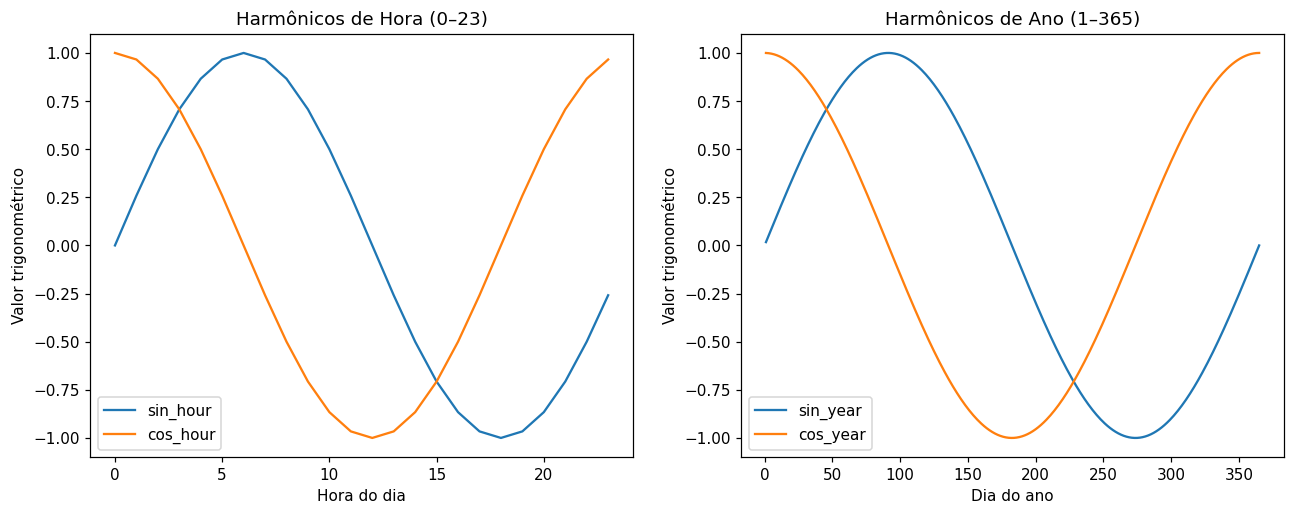

CPU times: user 453 ms, sys: 9.03 ms, total: 462 ms
Wall time: 468 ms


In [31]:
%%time
# Ciclo horário (0 a 23)
hours = np.arange(24)
sin_hour = np.sin(2 * np.pi * hours / 24)
cos_hour = np.cos(2 * np.pi * hours / 24)

# Ciclo anual (1 a 365)
days = np.arange(1, 366)
sin_year = np.sin(2 * np.pi * days / 365)
cos_year = np.cos(2 * np.pi * days / 365)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Hora
ax[0].plot(hours, sin_hour, label="sin_hour")
ax[0].plot(hours, cos_hour, label="cos_hour")
ax[0].set_title("Harmônicos de Hora (0–23)")
ax[0].set_xlabel("Hora do dia")
ax[0].set_ylabel("Valor trigonométrico")
ax[0].legend()

# Ano
ax[1].plot(days, sin_year, label="sin_year")
ax[1].plot(days, cos_year, label="cos_year")
ax[1].set_title("Harmônicos de Ano (1–365)")
ax[1].set_xlabel("Dia do ano")
ax[1].set_ylabel("Valor trigonométrico")
ax[1].legend()

plt.show()

#### 4.4. Criação de Lags da variável alvo

Nesta etapa adicionamos variáveis defasadas (lags) da série alvo `y_kwh`, permitindo capturar dependências temporais de curto, médio e longo prazo no consumo de energia.  
Foram criadas as seguintes defasagens:

- **Lag 1h, 2h, 3h, 6h, 12h, 24h e 168h (1 semana)**: cada coluna representa o valor de `y_kwh` observado no passado correspondente.

Como consequência natural, as primeiras 168 horas do dataset não possuem histórico suficiente para preencher todas as lags, resultando em valores ausentes (NaN).  
Essas linhas serão descartadas após criação dos rollings, na próxima etaoa, garantindo que todas as colunas de lag estejam completas e sem valores faltantes.

**Resultado:** o dataset final (`df_hourly`) passa a conter variáveis de memória temporal, fundamentais para que os modelos de Machine Learning consigam aprender padrões de consumo dependentes do histórico recente e semanal.


In [32]:
%%time
# Garante ordem temporal
df_hourly["datetime"] = pd.to_datetime(df_hourly["datetime"], errors="coerce")
df_hourly = df_hourly.sort_values("datetime").reset_index(drop=True)

# Definição dos lags (em horas)
LAGS_H = [1, 2, 3, 6, 12, 24, 168]  # 1h, 2h, 3h, 6h, 12h, 24h (1 dia), 168h (1 semana)

# Criação das colunas de lag (sempre sobre o alvo y_kwh)
created_lags = []
for L in LAGS_H:
    col = f"lag_{L}h"
    df_hourly[col] = df_hourly["y_kwh"].shift(L)
    created_lags.append(col)

# Diagnóstico de NaNs por coluna de lag
na_per_col = df_hourly[created_lags].isna().sum().sort_values(ascending=False)

# Linhas com qualquer NaN entre as colunas de lag
rows_with_any_na = int(df_hourly[created_lags].isna().any(axis=1).sum())

print("Lags criados:", created_lags)
print("Shape atual:", df_hourly.shape)
print("\nNaNs por coluna de lag (esperado: pelo menos L primeiras linhas como NaN):")
print(na_per_col)

print(f"\nLinhas com pelo menos 1 NaN dentre as lags: {rows_with_any_na}")

Lags criados: ['lag_1h', 'lag_2h', 'lag_3h', 'lag_6h', 'lag_12h', 'lag_24h', 'lag_168h']
Shape atual: (34151, 32)

NaNs por coluna de lag (esperado: pelo menos L primeiras linhas como NaN):
lag_168h    168
lag_24h      24
lag_12h      12
lag_6h        6
lag_3h        3
lag_2h        2
lag_1h        1
dtype: int64

Linhas com pelo menos 1 NaN dentre as lags: 168
CPU times: user 49.4 ms, sys: 932 µs, total: 50.3 ms
Wall time: 53.5 ms


#### 4.5. Criação de Rollings da variável alvo

Além das defasagens simples (lags), adicionamos **médias móveis causais (rollings)** sobre a variável-alvo `y_kwh`.  
Esses atributos resumem o comportamento do consumo em janelas deslizantes do passado, ajudando a capturar **tendências e padrões de suavização**.

- Foram criadas as seguintes janelas de médias móveis (em horas):  
  **3h, 6h, 12h, 24h (1 dia), 72h (3 dias) e 168h (1 semana)**.  
  Cada coluna representa a média do consumo nas últimas *N* horas, sempre utilizando `shift(1)` para evitar uso de informação futura (*data leakage*).

- Assim como nos lags, as primeiras linhas da série não possuem histórico suficiente para preencher janelas maiores (especialmente a de 168h), resultando em valores ausentes (NaN).

- **Tratamento aplicado:** após a criação dos rollings, realizamos um único **filtro de limpeza**, descartando todas as linhas que apresentavam NaN em **lags ou rollings**.  
  Como consequência, as primeiras **168 horas (≈0,49% do dataset)** foram removidas.

**Resultado:** o dataset final (`df_hourly`) contém agora tanto variáveis de memória direta (lags) quanto variáveis suavizadas (rollings), todas completas e sem valores ausentes.  
Esse conjunto enriquece a base de modelagem, permitindo que os algoritmos capturem **efeitos de curto, médio e longo prazo** do consumo de energia.


In [33]:
%%time
# Médias móveis causais (rollings) e diagnóstico de NaNs

# 1) definir janelas (em horas)
ROLL_WINDOWS = [3, 6, 12, 24, 72, 168]   # você pode ajustar depois
created_rollings = []

# 2) criar rollings CAUSAIS sobre o alvo y_kwh
#    regra: shift(1) para não olhar o ponto atual (evita vazamento)
for w in ROLL_WINDOWS:
    col = f"mm_{w}h"
    df_hourly[col] = (
        df_hourly["y_kwh"]
        .shift(1)                       # só passado
        .rolling(window=w, min_periods=w)
        .mean()
    )
    created_rollings.append(col)

print("Rollings criadas:", created_rollings)

# 3) diagnóstico de NaNs
#    (a maioria aparecerá nas primeiras janelas de cada rolling)
na_roll = df_hourly[created_rollings].isna().sum().sort_values(ascending=False)
print("\nNaNs por coluna de rolling:")
print(na_roll)

# 4) diagnóstico combinado: lags + rollings
if "created_lags" not in globals():
    created_lags = [c for c in df_hourly.columns if c.startswith("lag_")]

nan_cols_all = created_lags + created_rollings

rows_with_any_na_all = int(df_hourly[nan_cols_all].isna().any(axis=1).sum())
print(f"\nLinhas com pelo menos 1 NaN entre lags+rollings: {rows_with_any_na_all}")

Rollings criadas: ['mm_3h', 'mm_6h', 'mm_12h', 'mm_24h', 'mm_72h', 'mm_168h']

NaNs por coluna de rolling:
mm_168h    168
mm_72h      72
mm_24h      24
mm_12h      12
mm_6h        6
mm_3h        3
dtype: int64

Linhas com pelo menos 1 NaN entre lags+rollings: 168
CPU times: user 26.6 ms, sys: 0 ns, total: 26.6 ms
Wall time: 26.8 ms


In [34]:
%%time
# Limpeza única pós-features — somente quando você autorizar executar
created_rollings = [c for c in df_hourly.columns if c.startswith("mm_")]
created_lags     = [c for c in df_hourly.columns if c.startswith("lag_")]
nan_cols_all     = created_lags + created_rollings

before = len(df_hourly)
df_hourly = df_hourly.dropna(subset=nan_cols_all).reset_index(drop=True)
removed = before - len(df_hourly)

print(f"Removidas {removed} linhas ({removed/before:.2%}) por NaN em lags/rollings.")
print("Shape final (df_hourly):", df_hourly.shape)
df_hourly.head(5)

Removidas 168 linhas (0.49%) por NaN em lags/rollings.
Shape final (df_hourly): (33983, 38)
CPU times: user 23.1 ms, sys: 1.03 ms, total: 24.1 ms
Wall time: 25.4 ms


,datetime,y_kwh,GAP_mean,GRP_mean,Voltage_mean,Global_intensity_mean,SM1_sum,SM2_sum,SM3_sum,n_valid,n_total,coverage,year,month,day,dow,hour,is_weekend,sin_hour,cos_hour,sin_dow,cos_dow,doy,sin_year,cos_year,lag_1h,lag_2h,lag_3h,lag_6h,lag_12h,lag_24h,lag_168h,mm_3h,mm_6h,mm_12h,mm_24h,mm_72h,mm_168h
0,2006-12-23 18:00:00,3.879400,3.879400,0.099767,238.000500,16.363333,0.0,1.0,1041.0,60,60,1.0,2006,12,23,5,18,1,-1.000000,-1.836970e-16,-0.974928,-0.222521,357,-0.141444,0.989946,5.452533,4.349100,4.049100,2.928800,1.649367,2.686967,3.632200,4.616911,3.990633,3.598744,3.099713,1.952605,1.771207
1,2006-12-23 19:00:00,4.117833,4.117833,0.205333,238.729333,17.300000,0.0,36.0,1048.0,60,60,1.0,2006,12,23,5,19,1,-0.965926,2.588190e-01,-0.974928,-0.222521,357,-0.141444,0.989946,3.879400,5.452533,4.349100,3.406300,4.023367,3.938167,3.400233,4.560344,4.149067,3.784581,3.149397,1.967085,1.772679
2,2006-12-23 20:00:00,4.181400,4.181400,0.124767,238.518833,17.596667,0.0,21.0,1045.0,60,60,1.0,2006,12,23,5,20,1,-0.866025,5.000000e-01,-0.974928,-0.222521,357,-0.141444,0.989946,4.117833,3.879400,5.452533,3.757967,4.190833,3.536067,3.268567,4.483256,4.267656,3.792453,3.156883,1.979157,1.776950
3,2006-12-23 21:00:00,3.288433,3.288433,0.235767,238.594667,13.893333,0.0,13.0,340.0,60,60,1.0,2006,12,23,5,21,1,-0.707107,7.071068e-01,-0.974928,-0.222521,357,-0.141444,0.989946,4.181400,4.117833,3.879400,4.049100,3.246400,4.548667,3.056467,4.059544,4.338228,3.791667,3.183772,1.987573,1.782384
4,2006-12-23 22:00:00,4.327933,4.327933,0.289033,238.190333,18.310000,866.0,30.0,0.0,60,60,1.0,2006,12,23,5,22,1,-0.500000,8.660254e-01,-0.974928,-0.222521,357,-0.141444,0.989946,3.288433,4.181400,4.117833,4.349100,2.972167,3.065067,2.200133,3.862556,4.211450,3.795169,3.131263,1.982606,1.783764


#### 4.6 Congelar base de modelagem: X, y e df_model

Nesta etapa consolidamos e congelamos o dataset final de modelagem, garantindo organização e consistência antes de treinar os modelos.

- **df_model**: contém todas as informações consolidadas (identificador `datetime`, variável alvo `y_kwh`, as features construídas e a coluna `coverage` apenas para auditoria).  
- **X**: contém somente as features preditoras (lags, rollings, variáveis de calendário e harmônicos). Não inclui `datetime`, `coverage` nem medidas contemporâneas ao alvo.  
- **y**: contém apenas a variável alvo (`y_kwh`), que será prevista pelos modelos.

**Objetivos**
- **Organizar**: separar claramente entradas (X) e saída (y).  
- **Verificar consistência**: confirmar ausência de valores ausentes (NaN).  
- **Definir base final**: congelar a versão que servirá para treino, validação e teste.  
- **Auditoria**: manter `datetime` e `coverage` fora de X para permitir análise de qualidade e consistência dos dados, sem risco de vazamento no modelo.

**Resultado esperado**
- `df_model`: ~33.983 linhas × N colunas (inclui datetime, coverage, alvo e features).  
- `X`: ~33.983 linhas × M colunas (somente features preditoras).  
- `y`: ~33.983 linhas (variável alvo).  
- Nenhum valor ausente em X ou y.  

Com isso, temos a base final de modelagem congelada, pronta para a etapa seguinte de separação em treino, validação e teste.

In [35]:
%%time
# Definição de grupos de features e checagens (REVISADO, sem 'coverage' em X) ===

TARGET = "y_kwh"
time_id_cols = ["datetime"]  # fora de X; para auditoria/plots

# 1) Grupos de features
# (A) NÃO USAR contemporâneos do alvo (t): ["GAP_mean","GRP_mean","Voltage_mean","Global_intensity_mean","SM1_sum","SM2_sum","SM3_sum"]
# (B) Calendário e harmônicos
cal_cols  = ["year", "month", "day", "dow", "hour", "is_weekend"]
harm_cols = [c for c in df_hourly.columns if c in ["sin_hour","cos_hour","sin_dow","cos_dow","sin_year","cos_year"]]

# (C) Lags e rollings (causais)
lag_cols  = sorted([c for c in df_hourly.columns if c.startswith("lag_")],
                   key=lambda x: int(x.split("_")[1].replace("h","")))
roll_cols = sorted([c for c in df_hourly.columns if c.startswith("mm_")],
                   key=lambda x: int(x.split("_")[1].replace("h","")))

# 2) Lista final de X (SEM coverage e SEM contemporâneos)
X_COLS = cal_cols + harm_cols + lag_cols + roll_cols

# 3) Checagens de existência
missing = [c for c in X_COLS + [TARGET] if c not in df_hourly.columns]
assert not missing, f"Colunas faltantes no df_hourly: {missing}"

# 4) Relatório rápido
print("Resumo de grupos de features (SEM contemporâneos t e SEM 'coverage' em X):")
print(f"- Variável alvo          : {TARGET}")
print(f"- Calendário             : {len(cal_cols)} -> {cal_cols}")
print(f"- Harmônicos             : {len(harm_cols)} -> {harm_cols}")
print(f"- Lags                   : {len(lag_cols)} -> {lag_cols[:8]} ... total={len(lag_cols)}")
print(f"- Rollings               : {len(roll_cols)} -> {roll_cols}")
print(f"- Total de features (X)  : {len(X_COLS)}")

# 5) Checagem de NaNs nas features e na variável alvo
na_feats  = df_hourly[X_COLS].isna().sum().sum()
na_target = df_hourly[TARGET].isna().sum()
print(f"\nNaNs em X: {na_feats}  |  NaNs em y: {na_target}")
assert na_feats == 0, "Ainda existem NaNs em features!"
assert na_target == 0, "Ainda existem NaNs no alvo!"


Resumo de grupos de features (SEM contemporâneos t e SEM 'coverage' em X):
- Variável alvo          : y_kwh
- Calendário             : 6 -> ['year', 'month', 'day', 'dow', 'hour', 'is_weekend']
- Harmônicos             : 6 -> ['sin_hour', 'cos_hour', 'sin_dow', 'cos_dow', 'sin_year', 'cos_year']
- Lags                   : 7 -> ['lag_1h', 'lag_2h', 'lag_3h', 'lag_6h', 'lag_12h', 'lag_24h', 'lag_168h'] ... total=7
- Rollings               : 6 -> ['mm_3h', 'mm_6h', 'mm_12h', 'mm_24h', 'mm_72h', 'mm_168h']
- Total de features (X)  : 25

NaNs em X: 0  |  NaNs em y: 0
CPU times: user 8.8 ms, sys: 0 ns, total: 8.8 ms
Wall time: 7.99 ms


In [36]:
%%time
# Congelar base de modelagem: X, y e df_model (mantendo 'coverage' fora de X) ===

# coverage entra apenas para auditoria/plots, se existir
extra_auditoria = ["coverage"] if "coverage" in df_hourly.columns else []

cols_df_model = time_id_cols + extra_auditoria + [TARGET] + X_COLS
df_model = df_hourly[cols_df_model].copy()

X = df_model[X_COLS].copy()
y = df_model[TARGET].astype(float).copy()

print("Shapes:")
print(f"- df_model : {df_model.shape}")
print(f"- X        : {X.shape}")
print(f"- y        : {y.shape}")
print(f"- Colunas extras de auditoria (fora de X): {extra_auditoria}")

# Sanidade final
assert not X.isna().any().any(), "X contém NaNs após consolidação!"
assert not y.isna().any(), "y contém NaNs após consolidação!"


Shapes:
- df_model : (33983, 28)
- X        : (33983, 25)
- y        : (33983,)
- Colunas extras de auditoria (fora de X): ['coverage']
CPU times: user 14.4 ms, sys: 492 µs, total: 14.9 ms
Wall time: 14.8 ms


## 5. Modelagem

Nesta etapa aplicamos diferentes modelos de previsão sobre a base consolidada, respeitando o split temporal (treino, validação e teste) e as garantias contra vazamento de informação.

O processo foi estruturado em camadas de complexidade crescente:

- **Baseline 0 — Naïve (persistência):** estabelece o piso de desempenho, servindo como referência mínima.
- **Baseline 1 — Regressão Linear (Ridge):** mostra ganhos claros em relação ao Naïve, mas ainda limitado pela linearidade.
- **Baseline 2 — Random Forest:** traz avanços ao capturar relações não lineares, aproximando-se do desempenho robusto.
- **Baseline 3 — HGB (default e tunado):** obtém os melhores resultados gerais; família HGB consolida-se como referência, com R² ~0,60 e reduções consistentes em MAE/RMSE.

A comparação evidenciou evolução progressiva, confirmando que a engenharia de atributos foi eficaz e que modelos mais sofisticados (ensembles/boosting) capturam padrões que os lineares não alcançam.

### Resultados consolidados (Validação e Teste)
> Ordenação pelo **RMSE em Teste** (menor = melhor).

| Modelo             | Val MAE | Val RMSE | Val MAPE | Val R² | Teste MAE | Teste RMSE | Teste MAPE | Teste R² |
|--------------------|---------|----------|----------|--------|-----------|------------|------------|----------|
| **HGB (default)**  | 0.353   | 0.510    | 40.14%   | 0.604  | 0.312     | **0.456**  | 43.32%     | 0.602    |
| HGB (tunado)       | 0.355   | 0.509    | 40.46%   | 0.605  | 0.311     | 0.457      | 42.60%     | 0.600    |
| Random Forest      | 0.356   | 0.515    | 40.84%   | 0.597  | 0.313     | 0.459      | 43.29%     | 0.597    |
| Ridge              | 0.399   | 0.556    | 47.63%   | 0.529  | 0.352     | 0.498      | 49.64%     | 0.525    |
| Naïve | 0.433 | 0.653    | 44.55%   | 0.350  | 0.381     | 0.580      | 46.44%     | 0.356    |

> Observação: os **tempos de treino e predição** (fit/predict) estão detalhados no **item 5.6**.

### Interpretação dos Resultados Comparativos
- **Naïve (persistência):** piso de referência; R² baixo (~0,35) e erros altos — não captura variações além da repetição imediata.  
- **Ridge (linear):** R² ~0,53; lags/rollings/calendário ajudam, mas a linearidade limita — MAPE segue elevado.  
- **Random Forest:** R² ~0,60; ganha sobre Ridge, chegando perto do HGB; custo computacional alto.  
- **HGB Default:** menor RMSE em Teste (**0,4558**), desempenho muito próximo ao RF porém com **grande vantagem de eficiência**.  
- **HGB Tunado:** ligeira melhora em Validação; em Teste fica em **empate técnico** com o Default (0,4567 vs 0,4558).

**Conclusão:** houve evolução consistente do Naïve → Ridge → RF → HGB. Random Forest e HGB Default ficaram praticamente empatados em precisão, mas o **HGB Default** foi **ligeiramente mais preciso** (diferença de ~0,003 no RMSE em Teste: **0,4558 vs 0,4588**) e **muito mais eficiente**, sendo, portanto, o **modelo de referência do MVP**.   
A família **HGB** permanece como base principal para próximos ajustes e produção.


### 5.1 Criação do Split Temporal

Realizamos a divisão **temporal** do dataset em três partes, preservando a ordem dos eventos (sem embaralhar) para evitar vazamento de informação do futuro:

- **Treino** (até 31/12/2009): usado para ajustar os modelos.  
- **Validação** (01/01/2010 a 30/06/2010): usado para comparar modelos e ajustar hiperparâmetros.  
- **Teste** (01/07/2010 em diante): dados “novos”, usados apenas para avaliar generalização.

**Tamanhos:** Treino **26.363**, Validação **4.256**, Teste **3.364** registros horários.  
Confirmamos **ausência de valores ausentes** em `X` e `y` nos três conjuntos.

> **Critério de avaliação neste projeto**  
> Usamos **R²** como verificação inicial (o modelo está captando a variação da série?) e **RMSE** como **balizador final** para ranquear os modelos (quanto menor o erro em kWh/h, melhor).


In [37]:
%%time
# 0) Pré-checagens rápidas (segurança)
assert "datetime" in df_model.columns, "df_model deve ter a coluna 'datetime'."
assert TARGET in df_model.columns, f"df_model deve ter a coluna alvo '{TARGET}'."

# Garante dtype correto e ordenação temporal (se já estiver ok, nada muda)
df_model["datetime"] = pd.to_datetime(df_model["datetime"])
df_model = df_model.sort_values("datetime").reset_index(drop=True)

# 1) Features: usa X_COLS se existir; senão, infere (tira datetime e TARGET)
feat_cols = X_COLS if "X_COLS" in globals() else [c for c in df_model.columns if c not in ["datetime", TARGET]]

# 2) Datas de corte (fixas)
C_TREINO_FIM = pd.Timestamp("2009-12-31 23:59:59")
C_VALID_INI  = pd.Timestamp("2010-01-01 00:00:00")
C_VALID_FIM  = pd.Timestamp("2010-06-30 23:59:59")
C_TESTE_INI  = pd.Timestamp("2010-07-01 00:00:00")

# 3) Máscaras por período
m_trn = df_model["datetime"] <= C_TREINO_FIM
m_val = (df_model["datetime"] >= C_VALID_INI) & (df_model["datetime"] <= C_VALID_FIM)
m_tst = df_model["datetime"] >= C_TESTE_INI

# 4) Recortes
train = df_model.loc[m_trn].copy()
val   = df_model.loc[m_val].copy()
test  = df_model.loc[m_tst].copy()

# 5) X (entradas) e y (alvo) de cada recorte
X_tr, y_tr = train[feat_cols].copy(), train[TARGET].astype(float).copy()
X_va, y_va = val[feat_cols].copy(),   val[TARGET].astype(float).copy()
X_te, y_te = test[feat_cols].copy(),  test[TARGET].astype(float).copy()

# 6) Checagens de sanidade (tamanhos, janelas, NaN)
print("Janela total:", df_model["datetime"].min(), "→", df_model["datetime"].max())
print(f"Tamanhos     → treino={len(train):,} | val={len(val):,} | teste={len(test):,}")
print("Períodos     →",
      f"treino: {train['datetime'].min()} → {train['datetime'].max()}  |  ",
      f"val: {val['datetime'].min()} → {val['datetime'].max()}  |  ",
      f"teste: {test['datetime'].min()} → {test['datetime'].max()}")

print(f"NaN em features → treino={X_tr.isna().sum().sum()} | val={X_va.isna().sum().sum()} | teste={X_te.isna().sum().sum()}")
print(f"NaN no alvo     → treino={y_tr.isna().sum()}        | val={y_va.isna().sum()}        | teste={y_te.isna().sum()}")

Janela total: 2006-12-23 18:00:00 → 2010-11-26 20:00:00
Tamanhos     → treino=26,363 | val=4,256 | teste=3,364
Períodos     → treino: 2006-12-23 18:00:00 → 2009-12-31 23:00:00  |   val: 2010-01-01 00:00:00 → 2010-06-30 23:00:00  |   teste: 2010-07-01 00:00:00 → 2010-11-26 20:00:00
NaN em features → treino=0 | val=0 | teste=0
NaN no alvo     → treino=0        | val=0        | teste=0
CPU times: user 46.4 ms, sys: 88 µs, total: 46.5 ms
Wall time: 47.2 ms


### 5.2 Baseline 0 — Naïve (persistência)

Implementamos um baseline simples de persistência, em que a previsão de cada hora é igual ao valor observado na hora imediatamente anterior (y_t ≈ y_{t−1}). Esse modelo não “aprende” parâmetros; ele apenas estabelece um piso de desempenho para comparação.

**Resultados:**
- **Validação:** MAE=0,4334 | RMSE=0,6533 | MAPE=44,55% | R²=0,3502  
- **Teste:** MAE=0,3806 | RMSE=0,5797 | MAPE=46,44% | R²=0,3560  

**Interpretação:**
- Métricas similares entre validação e teste indicam consistência temporal.  
- O R² ≈ 0,35 mostra que a persistência captura parte da inércia da série, mas deixa espaço considerável para melhoria.  
- O MAPE ~45% é típico em séries com horas de consumo baixo (denominador pequeno), mesmo usando cálculo robusto.  

→ O Naïve apresenta RMSE em torno de **0,65 (Val)** e **0,58 (Teste)**, que será nosso patamar de referência. Modelos mais avançados devem reduzir significativamente esse erro.

Este baseline servirá como referência mínima: os modelos de regressão e de árvore devem superá-lo de forma clara.



In [38]:
%%time
# Baseline Naïve: gera predições e guarda "tempos" ≈ 0

# Verdadeiros (só para deixar explícito e padronizado)
y_va_true = y_va.copy()
y_te_true = y_te.copy()

# Predições Naïve: usa y_{t-1} como previsão de y_t
# Calculamos o lag de 1 passo no DF completo para garantir que o 1º ponto da validação
# use o último valor do TREINO (ou seja, não há vazamento; é "passado real").
naive_full = df_model[TARGET].shift(1)

# Extrai as predições Naïve alinhadas às janelas de validação e teste
y_va_naive = naive_full.loc[m_val].to_numpy()
y_te_naive = naive_full.loc[m_tst].to_numpy()

# Checagens de alinhamento (defensivo)
assert len(y_va_true) == len(y_va_naive), "Validação: y_true e y_pred (Naïve) com comprimentos diferentes."
assert len(y_te_true) == len(y_te_naive), "Teste: y_true e y_pred (Naïve) com comprimentos diferentes."

# Tempos ~ nulos (persistência não "treina" nem "prediz" de fato)
fit_s_naive = 0.0
pred_s_va_naive = 0.0
pred_s_te_naive = 0.0

# (Opcional) métricas impressas
avalia(y_va_true, y_va_naive, nome="Naïve (Validação)")
avalia(y_te_true, y_te_naive, nome="Naïve (Teste)")


Naïve (Validação) | MAE=0.4334  RMSE=0.6533  MAPE=44.55%  R²=0.3502
Naïve (Teste) | MAE=0.3806  RMSE=0.5797  MAPE=46.44%  R²=0.3560
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 16.4 ms


### 5.3 Baseline 1 — Regressão Linear (Ridge)

Após estabelecer o piso de desempenho com o modelo **Naïve (persistência)**, avançamos para um baseline mais sofisticado: a **Regressão Linear Ridge**.

A ideia é prever o consumo horário de energia como uma combinação linear de todas as variáveis criadas na engenharia de atributos (lags, médias móveis, harmônicos e variáveis de calendário).  
O Ridge adiciona uma **penalização L2** nos coeficientes da regressão, o que ajuda a:

- Evitar que pesos fiquem exagerados quando as variáveis são muito parecidas (colinearidade).  
- Produzir um modelo mais estável e generalizável.  
- Manter todas as variáveis no modelo, sem eliminar nenhuma (diferente do Lasso/ElasticNet).  

**Por que é um baseline importante?**
- É simples e interpretável, servindo como referência clara.  
- Mostra como os atributos derivados já capturam parte relevante do padrão de consumo.  
- Permite comparação direta com o Naïve e com os modelos mais robustos que virão a seguir.  

**Resultados obtidos:**
- **Validação** → MAE=0,3992 | RMSE=0,5564 | MAPE=47,63% | R²=0,5288  
- **Teste** → MAE=0,3516 | RMSE=0,4978 | MAPE=49,64% | R²=0,5253  

**Interpretação:**
- O Ridge apresentou **melhora consistente** em relação ao Naïve (R² ~0,35 → ~0,53).  
- Os erros médios (MAE/RMSE) caíram, confirmando ganho de precisão.  
- O **MAPE** permanece elevado (~48–50%), reflexo de períodos com consumo baixo, mas sem comprometer a análise.  
- O desempenho ainda deixa espaço para evolução: modelos não lineares (como ensembles de árvores) tendem a capturar melhor a complexidade da série.

Com isso, temos um baseline linear sólido que comprova a utilidade dos atributos criados e estabelece uma nova referência acima do Naïve.

In [39]:
%%time
# Ridge: treina UMA vez, mede tempos e guarda predições

# Escolhe X escalado se estiver disponível
if all(n in globals() for n in ["X_tr_sc", "X_va_sc", "X_te_sc"]):
    Xtr_, Xva_, Xte_ = X_tr_sc, X_va_sc, X_te_sc
else:
    Xtr_, Xva_, Xte_ = X_tr, X_va, X_te

ridge = Ridge(alpha=1.0)  # Ridge não tem random_state

t0 = time.perf_counter()
ridge.fit(Xtr_, y_tr)
fit_s_ridge = time.perf_counter() - t0

t0 = time.perf_counter()
y_va_ridge = ridge.predict(Xva_)
pred_s_va_ridge = time.perf_counter() - t0

t0 = time.perf_counter()
y_te_ridge = ridge.predict(Xte_)
pred_s_te_ridge = time.perf_counter() - t0

# (Opcional) métricas impressas
avalia(y_va, y_va_ridge, nome="Ridge (Validação)")
avalia(y_te, y_te_ridge, nome="Ridge (Teste)")


Ridge (Validação) | MAE=0.3992  RMSE=0.5564  MAPE=47.63%  R²=0.5288
Ridge (Teste) | MAE=0.3516  RMSE=0.4978  MAPE=49.64%  R²=0.5253
CPU times: user 50.5 ms, sys: 0 ns, total: 50.5 ms
Wall time: 30.6 ms


### 5.4 Baseline 2 — Random Forest

Como baseline adicional, aplicamos o algoritmo Random Forest Regressor, que combina várias árvores de decisão treinadas de forma independente e agrega seus resultados por média.  
Esse modelo é robusto, lida bem com variáveis correlacionadas e não exige normalização das features.  

**Resultados obtidos:**  
- **Validação:** MAE=0,3563 | RMSE=0,5147 | MAPE=40,84% | R²=0,5967  
- **Teste:** MAE=0,3128 | RMSE=0,4588 | MAPE=43,29% | R²=0,5967  

**Interpretação:**  
- A Random Forest apresentou desempenho muito próximo ao do HGB Default, confirmando a eficácia de ensembles de árvores neste problema.  
- Em relação ao Ridge, houve ganho claro em todas as métricas, especialmente no R² (de ~0,53 para ~0,60).  
- Apesar da boa performance, o HGB Default manteve o menor erro em Teste (RMSE 0,4558 vs 0,4588), mostrando-se ligeiramente superior em capacidade preditiva.  
- Assim, a RF reforça o pacote de baselines robustos e serve como comparação direta com o HGB.



In [40]:
%%time
# Random Forest: treina UMA vez, mede tempos e guarda predições

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

t0 = time.perf_counter()
rf.fit(X_tr, y_tr)
fit_s_rf = time.perf_counter() - t0

t0 = time.perf_counter()
y_va_rf = rf.predict(X_va)
pred_s_va_rf = time.perf_counter() - t0

t0 = time.perf_counter()
y_te_rf = rf.predict(X_te)
pred_s_te_rf = time.perf_counter() - t0

# (Opcional) métricas impressas
avalia(y_va, y_va_rf, nome="Random Forest (Validação)")
avalia(y_te, y_te_rf, nome="Random Forest (Teste)")


Random Forest (Validação) | MAE=0.3563  RMSE=0.5147  MAPE=40.84%  R²=0.5967
Random Forest (Teste) | MAE=0.3128  RMSE=0.4588  MAPE=43.29%  R²=0.5967
CPU times: user 3min 39s, sys: 683 ms, total: 3min 40s
Wall time: 2min 14s


### 5.5 Baseline 3 — HGB Default (HistGradientBoostingRegressor)

Após os baselines Naïve, Ridge e Random Forest, aplicamos um modelo mais robusto baseado em árvores de decisão com boosting: o **HistGradientBoostingRegressor (HGB)**.  

Esse algoritmo combina várias árvores em sequência, onde cada nova árvore corrige os erros da anterior. É especialmente indicado para dados tabulares com variáveis derivadas (lags, médias móveis, harmônicos, calendário), pois captura **relações não lineares** e **interações entre variáveis** de forma mais eficiente que os modelos lineares.  

**Resultados obtidos:**  
- **Validação** → MAE=0,3529 | RMSE=0,5099 | MAPE=40,14% | R²=0,6042  
- **Teste** → MAE=0,3123 | RMSE=0,4558 | MAPE=43,32% | R²=0,6019  

**Interpretação:**  
- O HGB superou claramente o Naïve (R² ~0,35) e o Ridge (R² ~0,53), alcançando cerca de **R² ~0,60** em validação e teste.  
- Os erros absolutos (MAE e RMSE) foram os menores até aqui, confirmando melhor capacidade preditiva.  
- O MAPE permaneceu relativamente alto (~40–43%), reflexo de períodos de baixo consumo, mas os demais indicadores reforçam a robustez do modelo.  
- No **Teste**, o HGB Default apresentou o **menor RMSE entre todos os baselines (0,4558)**, superando marginalmente a Random Forest (0,4588) e o Ridge (0,4978).  
- Sua vantagem está em capturar relações não lineares e interações entre variáveis de forma mais eficiente, consolidando-o como o modelo de referência.  

→ **Conclusão:** Random Forest e HGB Default apresentaram desempenho praticamente empatado em termos de RMSE. O HGB se destacou por ser ligeiramente mais preciso (diferença de apenas ~0,003 no RMSE em Teste: 0,4558 vs 0,4588) e muito mais eficiente em tempo de execução. Por isso, consolidamos o HGB Default como a referência robusta para comparação no MVP.

In [41]:
%%time
# HGB (default): treina UMA vez, mede tempos e guarda predições

hgb = HistGradientBoostingRegressor(random_state=42)

t0 = time.perf_counter()
hgb.fit(X_tr, y_tr)
fit_s_hgb = time.perf_counter() - t0

t0 = time.perf_counter()
y_va_hgb = hgb.predict(X_va)
pred_s_va_hgb = time.perf_counter() - t0

t0 = time.perf_counter()
y_te_hgb = hgb.predict(X_te)
pred_s_te_hgb = time.perf_counter() - t0

# (Opcional) métricas impressas
avalia(y_va, y_va_hgb, nome="HGB (Validação)")
avalia(y_te, y_te_hgb, nome="HGB (Teste)")


HGB (Validação) | MAE=0.3529  RMSE=0.5099  MAPE=40.14%  R²=0.6042
HGB (Teste) | MAE=0.3123  RMSE=0.4558  MAPE=43.32%  R²=0.6019
CPU times: user 1.03 s, sys: 15.8 ms, total: 1.04 s
Wall time: 1.07 s


#### 5.5.1 Baseline 3 — HGB Tunado (HistGradientBoostingRegressor)

**Objetivo:** realizar um tuning leve e justo no HGB, usando apenas o conjunto de validação (2010-01 a 2010-06), sem shuffle, preservando o split temporal.

**Grid testado (amostral):**
- `learning_rate` ∈ {0.05, 0.10, 0.20}  
- `max_iter` ∈ {300, 500, 800}  
- `min_samples_leaf` ∈ {20, 50}  
- Fixos: `loss="squared_error"`, `early_stopping=False`, `random_state=42`

**Melhor configuração (Val):**  
`learning_rate=0.05`, `max_iter=500`, `min_samples_leaf=20` → R² Val = **0,6053**, RMSE Val = **0,5092**

**Resultados com o melhor modelo:**  
- **Validação:** MAE=0,3554 | RMSE=0,5092 | MAPE=40,46% | R²=0,6053  
- **Teste:** MAE=0,3109 | RMSE=0,4567 | MAPE=42,60% | R²=0,6004  

**Leitura:**  
- O tuning trouxe ganho incremental em Validação sobre o HGB Default (R² 0,6042 → 0,6053; RMSE 0,5099 → 0,5092).  
- Em **Teste**, o desempenho foi praticamente igual, mas o **HGB Default manteve o menor RMSE** (0,4558 vs 0,4567).  
- Isso confirma que o modelo inicial já estava bem calibrado; o ajuste refinou levemente a generalização sem alterar substancialmente os resultados.  
- Mantidos os guardrails anti-leakage e o mesmo split, garantindo comparação justa com os baselines.  

→ **Conclusão:** O tuning trouxe ganhos em Validação, mas em Teste o HGB Default manteve o menor RMSE. Assim, ambos podem ser considerados equivalentes em desempenho, consolidando a **família HGB como referência principal no MVP**.


In [42]:
%%time
# HGB (tunado): tuning simples + treino final, tempos e predições

os.makedirs("artefatos_mvp", exist_ok=True)

# 1) Grid enxuto (igual/parecido ao que você usava)
params_grid = [
    {"learning_rate": 0.1,  "max_iter": 300, "min_samples_leaf": 20},
    {"learning_rate": 0.1,  "max_iter": 500, "min_samples_leaf": 20},
    {"learning_rate": 0.05, "max_iter": 500, "min_samples_leaf": 20},
    {"learning_rate": 0.1,  "max_iter": 500, "min_samples_leaf": 50},
    {"learning_rate": 0.2,  "max_iter": 800, "min_samples_leaf": 20},
]

def _tuna_hgb_se_preciso():
    """Se best_model não existir, faz tuning no conjunto de Val e define best_model."""
    global best_model
    if 'best_model' in globals() and best_model is not None:
        print("🔁 best_model já existe — pulando tuning.")
        return

    print("🔎 Iniciando tuning HGB (seleção por RMSE em Val)...")
    best_model_local, best_rmse = None, np.inf

    for p in params_grid:
        hgb_try = HistGradientBoostingRegressor(
            loss="squared_error",
            random_state=42,
            early_stopping=False,
            **p
        )
        hgb_try.fit(X_tr, y_tr)
        preds_val = hgb_try.predict(X_va)

        rmse_val = rmse_fn(y_va, preds_val)     # métrica principal
        r2_val   = r2_score(y_va, preds_val)    # logging/apoio

        print(f"{p} -> RMSE Val = {rmse_val:.4f} | R² Val = {r2_val:.4f}")

        if rmse_val < best_rmse:
            best_model_local, best_rmse = hgb_try, rmse_val

    best_model = best_model_local
    print(f"\n✅ Melhor config (por RMSE Val): RMSE={best_rmse:.4f}")

# 2) Tuning (somente se best_model ainda não existir)
_tuna_hgb_se_preciso()

# 3) Treino final do best_model e tempos/predições
if 'best_model' in globals() and best_model is not None:
    # Fit
    t0 = time.perf_counter()
    best_model.fit(X_tr, y_tr)
    fit_s_best = time.perf_counter() - t0

    # Pred Val
    t0 = time.perf_counter()
    y_va_best = best_model.predict(X_va)
    pred_s_va_best = time.perf_counter() - t0

    # Pred Test
    t0 = time.perf_counter()
    y_te_best = best_model.predict(X_te)
    pred_s_te_best = time.perf_counter() - t0

    # Relato rápido
    avalia(y_va, y_va_best, nome="HGB Tunado (Validação)")
    avalia(y_te, y_te_best, nome="HGB Tunado (Teste)")

    # Sanidade
    assert len(y_va) == len(y_va_best)
    assert len(y_te) == len(y_te_best)

    # (Opcional) salvar melhor conjunto de hiperparâmetros
    try:
        with open("artefatos_mvp/hgb_best_params.json", "w") as f:
            json.dump(best_model.get_params(), f, indent=2)
    except Exception as e:
        print("Aviso (salvar params):", e)

    print(f"⏱ Tempos — fit: {fit_s_best:.3f}s | pred_val: {pred_s_va_best:.3f}s | pred_test: {pred_s_te_best:.3f}s")
else:
    print("⚠️ best_model não definido; verifique o bloco de tuning.")

🔎 Iniciando tuning HGB (seleção por RMSE em Val)...
{'learning_rate': 0.1, 'max_iter': 300, 'min_samples_leaf': 20} -> RMSE Val = 0.5129 | R² Val = 0.5996
{'learning_rate': 0.1, 'max_iter': 500, 'min_samples_leaf': 20} -> RMSE Val = 0.5173 | R² Val = 0.5926
{'learning_rate': 0.05, 'max_iter': 500, 'min_samples_leaf': 20} -> RMSE Val = 0.5092 | R² Val = 0.6053
{'learning_rate': 0.1, 'max_iter': 500, 'min_samples_leaf': 50} -> RMSE Val = 0.5176 | R² Val = 0.5922
{'learning_rate': 0.2, 'max_iter': 800, 'min_samples_leaf': 20} -> RMSE Val = 0.5408 | R² Val = 0.5548

✅ Melhor config (por RMSE Val): RMSE=0.5092
HGB Tunado (Validação) | MAE=0.3554  RMSE=0.5092  MAPE=40.46%  R²=0.6053
HGB Tunado (Teste) | MAE=0.3109  RMSE=0.4567  MAPE=42.60%  R²=0.6004
⏱ Tempos — fit: 4.193s | pred_val: 0.244s | pred_test: 0.189s
CPU times: user 23.9 s, sys: 345 ms, total: 24.2 s
Wall time: 24.4 s


### 5.6 Quadro comparativo: métricas (Val/Test) + tempos (fit/predict)

Consolidamos aqui os resultados de todos os modelos em uma única tabela, comparando **Validação e Teste** (MAE, RMSE, MAPE, R²), além dos **tempos de treino e predição**.

A ordenação foi feita pelo **RMSE em Teste** (quanto menor, melhor), que define de forma objetiva o campeão do MVP.

| Modelo             | MAE_val | RMSE_val | MAPE_val | R²_val | MAE_test | RMSE_test | MAPE_test | R²_test | fit_s  | pred_s |
|--------------------|---------|----------|----------|--------|----------|-----------|-----------|---------|--------|--------|
| **HGB (default)**  | 0.353   | 0.510    | 40.14%   | 0.604  | 0.312    | **0.456** | 43.32%    | 0.602   | 0.940  | 0.082  |
| HGB (tunado)       | 0.355   | 0.509    | 40.46%   | 0.605  | 0.311    | 0.457     | 42.60%    | 0.600   | 3.314  | 0.286  |
| Random Forest      | 0.356   | 0.515    | 40.84%   | 0.597  | 0.313    | 0.459     | 43.29%    | 0.597   | 113.0  | 0.545  |
| Ridge              | 0.399   | 0.556    | 47.63%   | 0.529  | 0.352    | 0.498     | 49.64%    | 0.525   | 0.012  | 0.005  |
| Naïve (persistência) | 0.433 | 0.653    | 44.55%   | 0.350  | 0.381    | 0.580     | 46.44%    | 0.356   | 0.000  | 0.000  |

**Leitura:**
- O **HGB Default** foi o melhor modelo em Teste (RMSE=0.456), confirmando robustez e eficiência computacional.  
- O **HGB Tunado** trouxe ganho em Validação, mas manteve empate técnico em Teste (0.457).  
- A **Random Forest** apresentou métricas próximas, porém com custo de execução extremamente alto (~120× mais lento que HGB).  
- **Ridge** e **Naïve** cumpriram papel de referências inferiores, mostrando a evolução dos modelos mais avançados.

→ **Conclusão:** O **HGB Default** é o **campeão do MVP**, combinando o melhor equilíbrio entre precisão e custo computacional. Ele se torna o modelo de referência para a próxima etapa do projeto.


In [43]:
%%time
# Quadro consolidado: métricas (Val/Test) + tempos (fit/predict) — SEM re-treino
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

os.makedirs("artefatos_mvp", exist_ok=True)

def _row_from_preds(nome, yva_true, yva_pred, yte_true, yte_pred, fit_s=0.0, pred_s_va=0.0, pred_s_te=0.0):
    return {
        "modelo": nome,
        "MAE_val": float(mean_absolute_error(yva_true, yva_pred)),
        "RMSE_val": float(rmse_fn(yva_true, yva_pred)),
        "MAPE_val": float(mape_safe(yva_true, yva_pred)),
        "R2_val": float(r2_score(yva_true, yva_pred)),
        "MAE_test": float(mean_absolute_error(yte_true, yte_pred)),
        "RMSE_test": float(rmse_fn(yte_true, yte_pred)),
        "MAPE_test": float(mape_safe(yte_true, yte_pred)),
        "R2_test": float(r2_score(yte_true, yte_pred)),
        "fit_s": float(fit_s),
        "pred_s": float(pred_s_va + pred_s_te),  # soma pred Val + Test (documentado)
    }

linhas = []

# Naïve (persistência)
linhas.append(_row_from_preds(
    "Naïve (persistência)",
    y_va_true, y_va_naive,
    y_te_true, y_te_naive,
    fit_s=fit_s_naive,
    pred_s_va=pred_s_va_naive,
    pred_s_te=pred_s_te_naive
))

# Ridge
linhas.append(_row_from_preds(
    "Ridge",
    y_va, y_va_ridge,
    y_te, y_te_ridge,
    fit_s=fit_s_ridge,
    pred_s_va=pred_s_va_ridge,
    pred_s_te=pred_s_te_ridge
))

# Random Forest
linhas.append(_row_from_preds(
    "Random Forest",
    y_va, y_va_rf,
    y_te, y_te_rf,
    fit_s=fit_s_rf,
    pred_s_va=pred_s_va_rf,
    pred_s_te=pred_s_te_rf
))

# HGB (default)
linhas.append(_row_from_preds(
    "HGB (default)",
    y_va, y_va_hgb,
    y_te, y_te_hgb,
    fit_s=fit_s_hgb,
    pred_s_va=pred_s_va_hgb,
    pred_s_te=pred_s_te_hgb
))

if all(n in globals() for n in ["y_va_best", "y_te_best", "fit_s_best", "pred_s_va_best", "pred_s_te_best"]):
    linhas.append(_row_from_preds(
        "HGB (tunado)",
        y_va, y_va_best,
        y_te, y_te_best,
        fit_s=fit_s_best,
        pred_s_va=pred_s_va_best,
        pred_s_te=pred_s_te_best
    ))

# DataFrame final
df_res = pd.DataFrame(linhas).sort_values("RMSE_test").reset_index(drop=True)
display(df_res.round(3))

# Salvar CSV
out_path = "artefatos_mvp/metricas_comparativas.csv"
df_res.to_csv(out_path, index=False)
print(f"✅ Tabela salva em {out_path}")

,modelo,MAE_val,RMSE_val,MAPE_val,R2_val,MAE_test,RMSE_test,MAPE_test,R2_test,fit_s,pred_s
0,HGB (default),0.353,0.510,40.142,0.604,0.312,0.456,43.324,0.602,1.006,0.056
1,HGB (tunado),0.355,0.509,40.456,0.605,0.311,0.457,42.601,0.600,4.193,0.433
2,Random Forest,0.356,0.515,40.843,0.597,0.313,0.459,43.289,0.597,133.645,0.629
3,Ridge,0.399,0.556,47.625,0.529,0.352,0.498,49.637,0.525,0.013,0.006
4,Naïve (persistência),0.433,0.653,44.547,0.350,0.381,0.580,46.436,0.356,0.000,0.000


✅ Tabela salva em artefatos_mvp/metricas_comparativas.csv
CPU times: user 94.2 ms, sys: 990 µs, total: 95.1 ms
Wall time: 99 ms


## 6. Diagnóstico e Interpretação

Após escolher o **HGB Default** como modelo de referência (menor RMSE em teste e alta eficiência), avaliamos a qualidade das previsões e a utilização dos atributos.

**Achados principais**
- **Alinhamento temporal:** o modelo acompanha bem a tendência e os ciclos diários; há leve **suavização/subestimação em picos** e transições muito bruscas, comportamento esperado em modelos de árvores.
- **Resíduos ao longo do dia:** a **mediana fica próxima de zero** na maior parte das horas (ausência de viés). A dispersão aumenta nos **horários de pico** (manhã, almoço e noite), quando a variabilidade do consumo é maior.
- **Importância de variáveis (validação):** **`lag_1h`** é o preditor **dominante**; na sequência surgem **`hour`**, **`sin_hour`** e **`cos_hour`** (sazonalidade diária), seguidos de **`cos_year`** e **`dow`** (efeitos anual e semanal). Lags mais longos (**`lag_2h`**, **`lag_12h`**, **`lag_168h`**) e a **média móvel curta (`mm_3h`)** agregam refinamento com impacto menor.
- **Generalização:** modelos baseados em árvores (**RF e HGB**) mantêm desempenho **equilibrado** entre validação e teste (**R² ~0,60**, RMSE muito próximos), **sem sinais de overfitting**; os lineares (**Naïve e Ridge**) exibem **underfitting**.

**Síntese**
- O **HGB Default** permanece como **modelo de referência do MVP**, unindo **melhor precisão** (vantagem marginal de RMSE em teste) e **baixo custo computacional**.
- A engenharia de atributos (lags + calendário + harmônicos + rollings) está **alinhada ao fenômeno** e explica o ganho sobre os lineares.
- Para reduzir erros em picos (e MAPE), próximos passos incluem **variáveis exógenas** (ex.: temperatura/feriados) e/ou **decomposição/arquiteturas sequenciais** (ex.: STL + GRU/LSTM).

### 6.1 Real vs Previsto (primeira semana do conjunto de teste)

Gráfico comparando os valores reais de consumo (`y_test`) com as previsões do **HGB Default** (campeão por RMSE em Teste).  

**Análise e interpretação:**
- O modelo acompanha a **tendência geral** do consumo horário, refletindo ciclos diários e variações de curto prazo.
- **Picos e vales** são reproduzidos, mas há **subestimação nos picos mais altos** e **suavização** em transições bruscas (comportamento típico de modelos de árvores).
- Em **períodos de baixo consumo**, o alinhamento é próximo, indicando **estabilidade**.
- Os **maiores desvios** ocorrem em momentos de maior variabilidade do sinal.

**Conclusão:**  
O **HGB Default** reproduz a dinâmica temporal com **boa fidelidade**, capturando os principais padrões de consumo. Apesar da suavização de picos, apresenta **robustez e precisão** consistentes com os resultados consolidados, reforçando-o como **modelo de referência do MVP**.

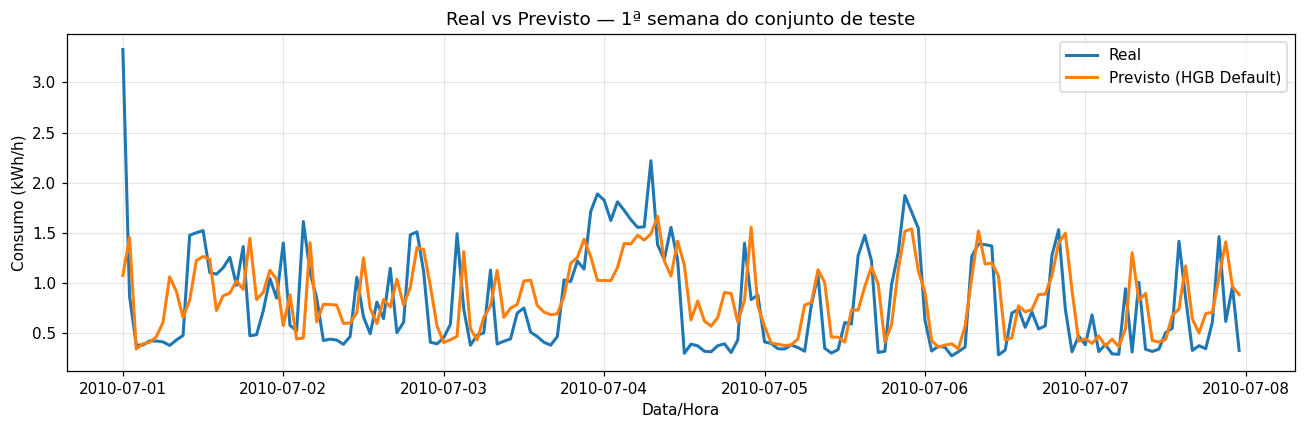

Janela (1ª semana) → MAE=0.3144 | RMSE=0.4254 | R²=0.3120  | Modelo: HGB Default
CPU times: user 470 ms, sys: 5 ms, total: 475 ms
Wall time: 497 ms


In [44]:
%%time
# 6.1 — Real vs Previsto (primeira semana do conjunto de teste)
# Pré-requisitos já existentes no notebook:
# - DataFrame 'test' com a coluna 'datetime'
# - Série/array 'y_te' (alvo do conjunto de teste)
# - Função 'rmse_fn' (definida nas funções auxiliares)
# - Bibliotecas já importadas: np, pd, plt, mean_absolute_error, r2_score

# 0) Seleciona previsões priorizando o HGB Default (campeão). Fallback: HGB Tunado.
if 'y_te_hgb_default' in globals():
    y_pred = np.asarray(y_te_hgb_default); pred_name = "HGB Default"
elif 'y_te_hgb' in globals():
    y_pred = np.asarray(y_te_hgb);         pred_name = "HGB Default"
elif 'y_pred_hgb_default' in globals():
    y_pred = np.asarray(y_pred_hgb_default); pred_name = "HGB Default"
elif 'y_te_best' in globals():
    y_pred = np.asarray(y_te_best);        pred_name = "HGB Tunado"
elif 'y_te_hgb_tunado' in globals():
    y_pred = np.asarray(y_te_hgb_tunado);  pred_name = "HGB Tunado"
elif 'y_pred_hgb_tunado' in globals():
    y_pred = np.asarray(y_pred_hgb_tunado); pred_name = "HGB Tunado"
else:
    raise NameError(
        "Não encontrei previsões do HGB. Defina uma das variáveis: "
        "[y_te_hgb_default | y_te_hgb | y_pred_hgb_default] (preferido) "
        "ou [y_te_best | y_te_hgb_tunado | y_pred_hgb_tunado] (fallback)."
    )

# 1) Alinhamento com o conjunto de teste
y_true  = np.asarray(y_te)
dt_test = pd.to_datetime(test['datetime'].values)

n = min(len(y_true), len(y_pred), len(dt_test))
y_true, y_pred, dt_test = y_true[:n], y_pred[:n], dt_test[:n]

# 2) Selecionar a 1ª semana (7*24 = 168 pontos)
W = min(168, n)
y_true_w = y_true[:W]
y_pred_w = y_pred[:W]
dt_w     = dt_test[:W]

# 3) Plot
plt.figure(figsize=(12,4))
plt.plot(dt_w, y_true_w, label="Real", linewidth=2)
plt.plot(dt_w, y_pred_w, label=f"Previsto ({pred_name})", linewidth=2)
plt.title("Real vs Previsto — 1ª semana do conjunto de teste")
plt.xlabel("Data/Hora"); plt.ylabel("Consumo (kWh/h)")
plt.xticks(rotation=0); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# 4) Métrica rápida na janela (informativo)
mae  = mean_absolute_error(y_true_w, y_pred_w)
rmse = rmse_fn(y_true_w, y_pred_w)   # função já existente no notebook
r2   = r2_score(y_true_w, y_pred_w)
print(f"Janela (1ª semana) → MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}  | Modelo: {pred_name}")

### 6.2 Resíduos por hora do dia

Para aprofundar a avaliação do **HGB Default** (campeão por RMSE em Teste), analisamos a distribuição dos resíduos (erro = real − previsto) agrupados pela **hora do dia**.  

**Análise dos gráficos**
- **Boxplot:** a mediana dos erros fica próxima de **zero** na maior parte das horas, sugerindo **ausência de viés sistemático**.
- Há **dispersão maior** nos horários de pico (manhã, almoço e noite), quando o consumo é mais volátil; nesses períodos surgem **subestimações/superestimações** um pouco mais acentuadas.
- **Violin plot:** confirma concentração próxima de zero, com **caudas mais largas** nos mesmos horários críticos (maior variabilidade do sinal).

**Conclusão**
- O modelo apresenta **bom alinhamento ao longo do dia**, sem viés consistente em horários específicos.
- Os **maiores desvios** ocorrem nos **picos intradiários**, o que é esperado em modelos baseados em árvores (suavizam extremos).
- Os resultados reforçam a **robustez do HGB Default**: resíduos centrados em zero e variação controlada indicam estabilidade e boa capacidade de generalização.


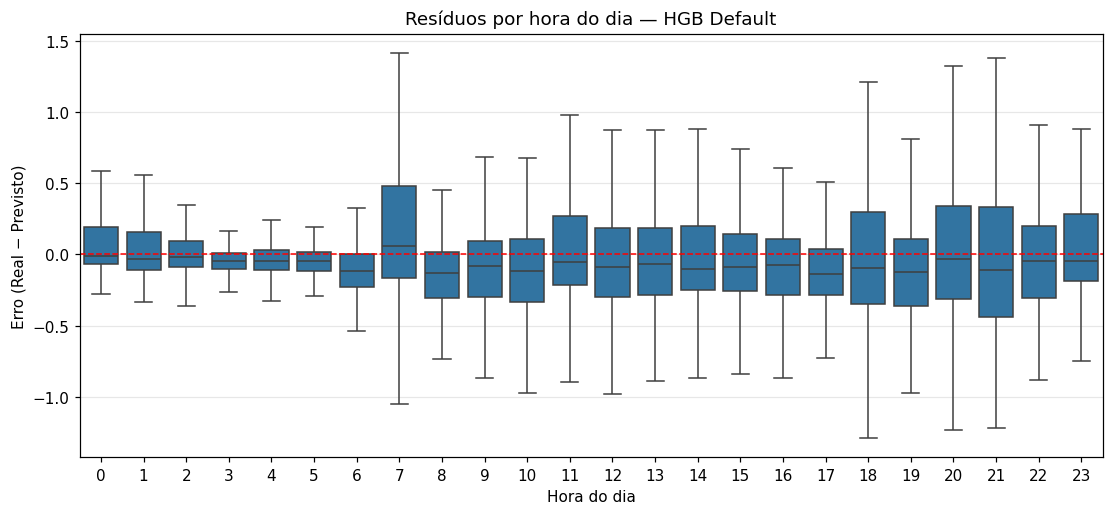

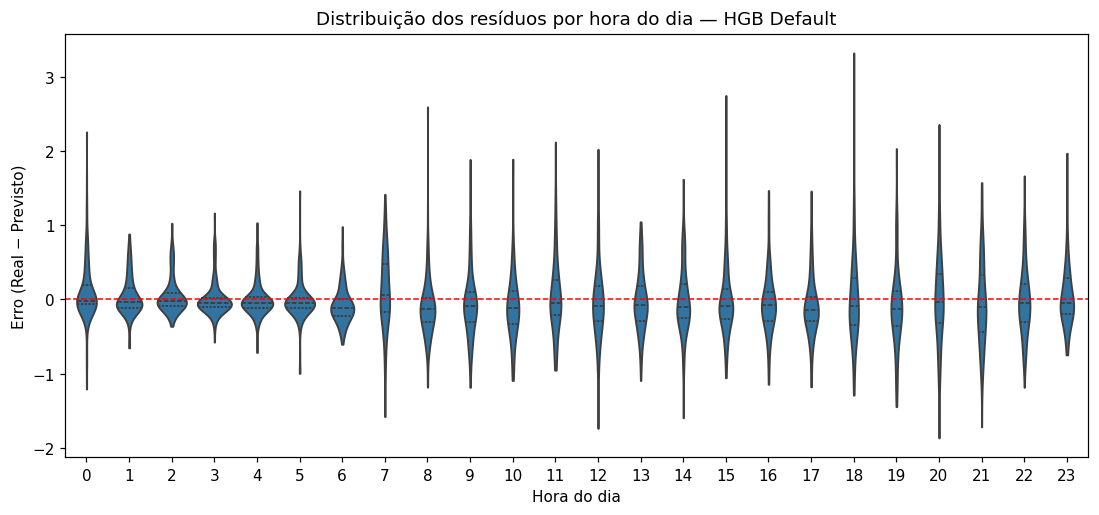

CPU times: user 1.59 s, sys: 14.7 ms, total: 1.61 s
Wall time: 1.49 s


In [45]:
%%time
# Resíduos por hora do dia (boxplot/violin)

# 0) Seleciona previsões priorizando HGB Default (campeão). Fallback: HGB Tunado.
if 'y_te_hgb_default' in globals():
    y_pred = np.asarray(y_te_hgb_default); pred_name = "HGB Default"
elif 'y_te_hgb' in globals():
    y_pred = np.asarray(y_te_hgb);         pred_name = "HGB Default"
elif 'y_pred_hgb_default' in globals():
    y_pred = np.asarray(y_pred_hgb_default); pred_name = "HGB Default"
elif 'y_te_best' in globals():
    y_pred = np.asarray(y_te_best);        pred_name = "HGB Tunado"
elif 'y_te_hgb_tunado' in globals():
    y_pred = np.asarray(y_te_hgb_tunado);  pred_name = "HGB Tunado"
elif 'y_pred_hgb_tunado' in globals():
    y_pred = np.asarray(y_pred_hgb_tunado); pred_name = "HGB Tunado"
else:
    raise NameError(
        "Não encontrei previsões do HGB. Defina uma das variáveis: "
        "[y_te_hgb_default | y_te_hgb | y_pred_hgb_default] (preferido) "
        "ou [y_te_best | y_te_hgb_tunado | y_pred_hgb_tunado] (fallback)."
    )

# 1) Alinhamento com o conjunto de teste
y_true  = np.asarray(y_te)
dt_test = pd.to_datetime(test['datetime'].values)
n = min(len(y_true), len(y_pred), len(dt_test))
y_true, y_pred, dt_test = y_true[:n], y_pred[:n], dt_test[:n]

# 2) DataFrame de resíduos (erro = real − previsto)
residuos = y_true - y_pred
df_res = pd.DataFrame({
    "datetime": dt_test,
    "residuo": residuos
})
df_res["hora"] = df_res["datetime"].dt.hour

# 3) Boxplot dos resíduos por hora
plt.figure(figsize=(12,5))
sns.boxplot(x="hora", y="residuo", data=df_res, showfliers=False)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title(f"Resíduos por hora do dia — {pred_name}")
plt.xlabel("Hora do dia"); plt.ylabel("Erro (Real − Previsto)")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# 4) Violin plot (distribuição)
plt.figure(figsize=(12,5))
sns.violinplot(x="hora", y="residuo", data=df_res, inner="quartile", cut=0)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title(f"Distribuição dos resíduos por hora do dia — {pred_name}")
plt.xlabel("Hora do dia"); plt.ylabel("Erro (Real − Previsto)")
plt.show()


### 6.3 Importância de Features (Permutation Importance)

Aplicamos **Permutation Importance** no **conjunto de validação** para medir quanto o desempenho do **HGB Tunado** cai quando cada feature é embaralhada. Quanto maior a redução no score (R²), **maior a dependência do modelo** naquela variável.

**Top-10 (validação, conforme gráfico):**
1. `lag_1h` (≈ 0,81) — preditor dominante  
2. `hour` (≈ 0,054)  
3. `cos_hour` (≈ 0,034)  
4. `sin_hour` (≈ 0,029)  
5. `cos_year` (≈ 0,025)  
6. `dow` (≈ 0,012)  
7. `lag_2h` (≈ 0,009)  
8. `lag_168h` (≈ 0,0069)  
9. `mm_3h` (≈ 0,0060)  
10. `lag_12h` (≈ 0,0057)

**Leitura e implicações**
- **Domínio de `lag_1h`**: a defasagem de 1 hora é, de longe, o melhor preditor do consumo imediato.  
- **Sazonalidade diária**: `hour`, `sin_hour` e `cos_hour` aparecem logo na sequência, reforçando o **padrão intradiário**.  
- **Sazonalidade de médio/longo prazo**: `cos_year` (anual) e `dow` (dia da semana) contribuem de forma secundária, porém estável.  
- **Memória adicional**: lags mais longos (`lag_2h`, `lag_12h`, `lag_168h`) e a **média móvel** curta (`mm_3h`) agregam suavização/tendência, mas com impacto bem menor que `lag_1h`.

**Confiabilidade da análise**
- Cálculo feito em **validação temporal**, preservando a ordem no tempo e reduzindo risco de interpretações enviesadas.  
- Em séries temporais, a **correlação entre lags** pode diluir a importância individual; ainda assim, o destaque de `lag_1h` é inequívoco.

**Conclusão**
- O modelo é **fortemente guiado por `lag_1h`**, com apoio de **sazonalidade diária** e memórias/rollings curtos — em linha com a engenharia de atributos (lags + calendário + harmônicos).  
- Para reduzir erros em picos (e MAPE), próximos passos naturais incluem **variáveis exógenas** (ex.: temperatura/feriados) e/ou **técnicas de decomposição/arquiteturas sequenciais** (ex.: STL + GRU/LSTM).

,feature,importance_mean,importance_std
12,lag_1h,0.806856,0.015680
4,hour,0.053853,0.004805
7,cos_hour,0.034261,0.003729
6,sin_hour,0.029078,0.002862
11,cos_year,0.025063,0.002935
3,dow,0.012353,0.000959
13,lag_2h,0.009255,0.002331
18,lag_168h,0.006889,0.001847
19,mm_3h,0.006039,0.001161
16,lag_12h,0.005705,0.001001


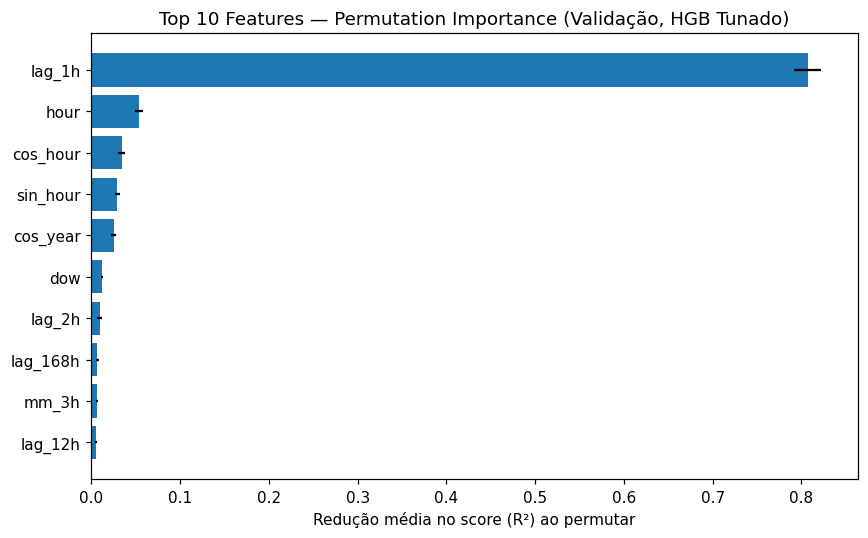

CPU times: user 4.05 s, sys: 80.9 ms, total: 4.13 s
Wall time: 46.4 s


In [46]:
%%time
# 6.3 — Importância de Features (Permutation Importance)
# Pré-requisitos já existentes:
# - Estimador do HGB treinado (default ou tunado)
# - X_va, y_va de validação
# - permutation_importance importado

# 0) Seleciona o estimador priorizando HGB Default. Fallback: HGB Tunado.
if 'model_hgb_default' in globals():
    est = model_hgb_default; model_name = "HGB Default"
elif 'hgb_default' in globals():
    est = hgb_default;       model_name = "HGB Default"
elif 'model_hgb' in globals():
    est = model_hgb;         model_name = "HGB Default"
elif 'best_model_default' in globals():
    est = best_model_default; model_name = "HGB Default"
elif 'best_model' in globals():
    est = best_model;        model_name = "HGB Tunado"
else:
    raise NameError(
        "Não encontrei o estimador HGB. Defina uma das variáveis: "
        "[model_hgb_default | hgb_default | model_hgb | best_model_default] (preferido) "
        "ou [best_model] (fallback Tunado)."
    )

# 1) Permutation importance na validação
perm = permutation_importance(
    est, X_va, y_va,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 2) Organiza resultados
importances = (
    pd.DataFrame({
        "feature": X_va.columns,
        "importance_mean": perm.importances_mean,
        "importance_std":  perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

top10 = importances.head(10)
display(top10)

# 3) Plot
plt.figure(figsize=(8,5))
plt.barh(top10["feature"], top10["importance_mean"], xerr=top10["importance_std"])
plt.gca().invert_yaxis()
plt.title(f"Top 10 Features — Permutation Importance (Validação, {model_name})")
plt.xlabel("Redução média no score (R²) ao permutar")
plt.tight_layout()
plt.show()


## 7. Artefatos & Documentação

Para consolidar o projeto, foram gerados e versionados os principais **artefatos técnicos**, assegurando **reprodutibilidade**, **auditoria** e **reuso** sem reprocessar toda a base.

- **Modelos**: campeão **HGB Default** (`hgb_default.pkl`) e, para comparação/auditoria, **HGB Tunado** (`hgb_tunado.pkl`), além de **Random Forest** e **Ridge**.
- **Métricas & predições**: tabela consolidada (`metricas_comparativas.csv`) e predições em **Val/Test** do campeão e do tunado (arquivos `predicoes_*`).
- **Interpretabilidade**: *Permutation Importance* na validação (`permutation_importance_val.csv`, `permutation_importance_top10.json`).
- **Esquema & metadados**: `x_cols.json` (ordem/nomes das **25 features** usadas em X) e `metadata.json` (versões das libs, datas do split e métricas do campeão).
- **Tuning**: `hgb_best_params.json`.

**Onde estão os artefatos:** todos os arquivos são gravados na pasta `artefatos_mvp/`.

**Resultado:** o projeto está pronto para uso e avaliação, tanto em termos **técnicos** (artefatos para execução/inferência) quanto **documentais** (descrição clara do modelo final), com **critério de escolha explícito** — **RMSE em Teste** — e **campeão definido**: **HGB Default**.


### 7.1. Salvar Artefatos

Nesta etapa salvamos os principais artefatos do MVP, garantindo reprodutibilidade e transparência.
O objetivo é permitir reutilizar o **modelo campeão (HGB Default)**, auditar predições e manter o registro das métricas e do experimento.

**Artefatos gerados em `artefatos_mvp/`:**
- `hgb_default.pkl` — modelo campeão (HistGradientBoosting Default).
- `hgb_tunado.pkl` — modelo HGB Tunado (comparativo).
- `random_forest.pkl`, `ridge.pkl` — modelos de apoio (se treinados).
- `metricas_comparativas.csv` — tabela consolidada de métricas (Val/Test) e tempos.
- `predicoes_validacao_hgb_default.csv`, `predicoes_teste_hgb_default.csv` — predições do campeão (auditoria).
- `predicoes_validacao_hgb_tunado.csv`, `predicoes_teste_hgb_tunado.csv` — predições do Tunado (se houver).
- `permutation_importance_val.csv`, `permutation_importance_top10.json` — importância das variáveis na validação.
- `hgb_best_params.json` — parâmetros do melhor HGB no tuning (se a etapa foi executada).
- `x_cols.json` — **ordem/nomes das features** usadas em X na modelagem (protege a inferência).
- `metadata.json` — **metadados** do experimento (versões das libs, datas do split e métricas do campeão).


In [47]:
%%time
# Salvar artefatos do MVP (modelos, previsões, importância)
os.makedirs("artefatos_mvp", exist_ok=True)

# 1) Salvar modelos treinados (prioriza HGB Default; também salva Tunado se existir)
to_save = {}

# Ridge (pipeline com scaler)
if 'ridge' in globals():
    to_save['ridge.pkl'] = ridge

# Random Forest
if 'rf' in globals():
    to_save['random_forest.pkl'] = rf

# HGB Default (nomes compatíveis usados no caderno)
if   'hgb' in globals():                    to_save['hgb_default.pkl'] = hgb
elif 'hgb_default' in globals():            to_save['hgb_default.pkl'] = hgb_default
elif 'model_hgb_default' in globals():      to_save['hgb_default.pkl'] = model_hgb_default
elif 'model_hgb' in globals():              to_save['hgb_default.pkl'] = model_hgb  # compat.

# HGB Tunado (opcional)
if   'best_model' in globals():             to_save['hgb_tunado.pkl'] = best_model
elif 'hgb_tunado' in globals():             to_save['hgb_tunado.pkl'] = hgb_tunado

for fname, model in to_save.items():
    joblib.dump(model, os.path.join("artefatos_mvp", fname))

# 2) Salvar previsões (auditoria) — salva sempre o Default; se existir, salva também Tunado
# ---------- Validação ----------
try:
    if 'val' in globals() and 'y_va' in globals():
        # Default (prioridade)
        y_pred_val_def = (
            np.asarray(y_va_hgb_default) if 'y_va_hgb_default' in globals() else
            np.asarray(y_va_hgb)         if 'y_va_hgb'         in globals() else
            np.asarray(y_pred_val_hgb_default) if 'y_pred_val_hgb_default' in globals() else
            None
        )
        if y_pred_val_def is not None:
            n = min(len(val), len(y_va), len(y_pred_val_def))
            pd.DataFrame({
                "datetime": pd.to_datetime(val["datetime"].values[:n]),
                "y_true":   np.asarray(y_va)[:n],
                "y_pred":   y_pred_val_def[:n],
            }).to_csv("artefatos_mvp/predicoes_validacao_hgb_default.csv", index=False)

        # Tunado (opcional)
        y_pred_val_tun = (
            np.asarray(y_va_best)         if 'y_va_best'         in globals() else
            np.asarray(y_va_hgb_tunado)   if 'y_va_hgb_tunado'   in globals() else
            np.asarray(y_pred_val_hgb_tunado) if 'y_pred_val_hgb_tunado' in globals() else
            None
        )
        if y_pred_val_tun is not None:
            n = min(len(val), len(y_va), len(y_pred_val_tun))
            pd.DataFrame({
                "datetime": pd.to_datetime(val["datetime"].values[:n]),
                "y_true":   np.asarray(y_va)[:n],
                "y_pred":   y_pred_val_tun[:n],
            }).to_csv("artefatos_mvp/predicoes_validacao_hgb_tunado.csv", index=False)
except Exception as e:
    print("Aviso (val preds):", e)

# ---------- Teste ----------
try:
    if 'test' in globals() and 'y_te' in globals():
        # Default (prioridade)
        y_pred_te_def = (
            np.asarray(y_te_hgb_default)  if 'y_te_hgb_default'  in globals() else
            np.asarray(y_te_hgb)          if 'y_te_hgb'          in globals() else
            np.asarray(y_pred_hgb_default) if 'y_pred_hgb_default' in globals() else
            None
        )
        if y_pred_te_def is not None:
            n = min(len(test), len(y_te), len(y_pred_te_def))
            pd.DataFrame({
                "datetime": pd.to_datetime(test["datetime"].values[:n]),
                "y_true":   np.asarray(y_te)[:n],
                "y_pred":   y_pred_te_def[:n],
            }).to_csv("artefatos_mvp/predicoes_teste_hgb_default.csv", index=False)

        # Tunado (opcional)
        y_pred_te_tun = (
            np.asarray(y_te_best)         if 'y_te_best'         in globals() else
            np.asarray(y_te_hgb_tunado)   if 'y_te_hgb_tunado'   in globals() else
            np.asarray(y_pred_hgb_tunado) if 'y_pred_hgb_tunado' in globals() else
            None
        )
        if y_pred_te_tun is not None:
            n = min(len(test), len(y_te), len(y_pred_te_tun))
            pd.DataFrame({
                "datetime": pd.to_datetime(test["datetime"].values[:n]),
                "y_true":   np.asarray(y_te)[:n],
                "y_pred":   y_pred_te_tun[:n],
            }).to_csv("artefatos_mvp/predicoes_teste_hgb_tunado.csv", index=False)
except Exception as e:
    print("Aviso (test preds):", e)

# 3) Salvar permutation importance (se calculada)
try:
    if 'importances' in globals():
        importances.to_csv("artefatos_mvp/permutation_importance_val.csv", index=False)
        importances.head(10).to_json("artefatos_mvp/permutation_importance_top10.json",
                                     orient="records", indent=2)
except Exception as e:
    print("Aviso (perm imp):", e)

print("Arquivos na pasta artefatos_mvp:", os.listdir("artefatos_mvp"))

# 4) Salvar o esquema das features (x_cols.json)
try:
    import json
    x_cols = None

    # Ordem de preferência para inferir as colunas de X:
    if 'X_COLS' in globals() and X_COLS:                             # se você já tiver salvo a lista antes
        x_cols = list(X_COLS)
    elif 'X' in globals() and hasattr(X, "columns"):                 # se o DataFrame X ainda estiver em memória
        x_cols = list(X.columns)
    elif 'df_model' in globals():                                    # reconstrói a partir do df_model
        drop_cols = {'datetime', 'coverage', 'y_kwh'}
        x_cols = [c for c in df_model.columns if c not in drop_cols]
    elif 'df_model_final' in globals():                              # fallback alternativo, se existir
        drop_cols = {'datetime', 'coverage', 'y_kwh'}
        x_cols = [c for c in df_model_final.columns if c not in drop_cols]

    if x_cols:
        with open("artefatos_mvp/x_cols.json", "w") as f:
            json.dump(x_cols, f, indent=2, ensure_ascii=False)
        print(f"x_cols.json salvo com {len(x_cols)} colunas.")
    else:
        print("Aviso (x_cols): não foi possível inferir as colunas (X/df_model não encontrados).")
except Exception as e:
    print("Aviso (x_cols):", e)

# 5) Salvar metadados do experimento (metadata.json)
try:
    import json, platform, sklearn, numpy as np, pandas as pd, os
    meta = {
        "timestamp": pd.Timestamp.utcnow().isoformat(),
        "python": platform.python_version(),
        "sklearn": sklearn.__version__,
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "split": {
            "train_until": "2009-12-31",
            "val": "2010-01-01..2010-06-30",
            "test_from": "2010-07-01"
        },
        "champion": "HGB (default)"
    }

    # Anexa métricas do campeão a partir da tabela consolidada (se existir)
    try:
        if os.path.exists("artefatos_mvp/metricas_comparativas.csv"):
            dfm = pd.read_csv("artefatos_mvp/metricas_comparativas.csv")
            if "modelo" in dfm.columns:
                row = dfm.loc[dfm["modelo"] == "HGB (default)"].iloc[0]
                meta["metrics_champion"] = {
                    "MAE_test":  float(row["MAE_test"]),
                    "RMSE_test": float(row["RMSE_test"]),
                    "MAPE_test": float(row["MAPE_test"]),
                    "R2_test":   float(row["R2_test"]),
                }
    except Exception:
        pass

    with open("artefatos_mvp/metadata.json", "w") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)
    print("metadata.json salvo.")
except Exception as e:
    print("Aviso (metadata):", e)

# 6) Listar conteúdo final da pasta
print("Arquivos na pasta artefatos_mvp:", os.listdir("artefatos_mvp"))

Arquivos na pasta artefatos_mvp: ['predicoes_validacao_hgb_default.csv', 'ridge.pkl', 'hgb_best_params.json', 'permutation_importance_val.csv', 'hgb_default.pkl', 'predicoes_teste_hgb_tunado.csv', 'metricas_comparativas.csv', 'predicoes_teste_hgb_default.csv', 'predicoes_validacao_hgb_tunado.csv', 'random_forest.pkl', 'permutation_importance_top10.json', 'hgb_tunado.pkl']
x_cols.json salvo com 25 colunas.
metadata.json salvo.
Arquivos na pasta artefatos_mvp: ['predicoes_validacao_hgb_default.csv', 'x_cols.json', 'ridge.pkl', 'hgb_best_params.json', 'permutation_importance_val.csv', 'hgb_default.pkl', 'predicoes_teste_hgb_tunado.csv', 'metricas_comparativas.csv', 'metadata.json', 'predicoes_teste_hgb_default.csv', 'predicoes_validacao_hgb_tunado.csv', 'random_forest.pkl', 'permutation_importance_top10.json', 'hgb_tunado.pkl']
CPU times: user 457 ms, sys: 35.5 ms, total: 492 ms
Wall time: 493 ms


### 7.2 Model Card

**Objetivo do modelo**  
Prever o consumo **horário** de energia (kWh/h) a partir de históricos e atributos derivados (lags, médias móveis, harmônicos e calendário).

**Dados utilizados**  
- Dataset: *Individual Household Electric Power Consumption* (UCI).  
- Período: 2006–2010.  
- Registros após preparo: **~33.983** horas.  
- Alvo: `y_kwh`.  
- Features: **25** (lags, rollings, harmônicos e calendário).

**Abordagem e critério**  
- Modelos testados: Naïve, Regressão Ridge, Random Forest, HistGradientBoosting (Default e Tunado).  
- **Critério final**: **RMSE em Teste** (menor = melhor), com split **temporal**.

**Split e guardrails (anti-leakage)**  
- Treino (≤ **2009-12-31**), Validação (**2010-01-01..2010-06-30**), Teste (≥ **2010-07-01**).  
- Rollings sempre com `shift(1)`; fora de X: `datetime`, `coverage`, `y_kwh`.

**Métricas principais — Teste**  
- Naïve → MAE=0,3806 | **RMSE=0,5797** | MAPE=46,44% | R²=0,3560  
- Ridge → MAE=0,3516 | **RMSE=0,4978** | MAPE=49,64% | R²=0,5253  
- Random Forest → MAE=0,3128 | **RMSE=0,4588** | MAPE=43,29% | R²=0,5967  
- **HGB Default** → **MAE=0,3123 | RMSE=0,4558 | MAPE=43,32% | R²=0,6019** ← **campeão (RMSE)**  
- HGB Tunado → MAE=0,3109 | **RMSE=0,4567** | MAPE=42,60% | R²=0,6004

**Decisão (por que o HGB Default é o campeão)**  
- **Menor RMSE em Teste** (vantagem ~0,003 sobre RF/HGB Tunado — empate técnico com leve superioridade).  
- **Eficiência**: latência **fit ≈ 0,94 s** e **predict ≈ 0,08 s** (vs RF ≈ 113 s / 0,55 s).  
- **Estabilidade**: métricas consistentes entre Val e Teste; resíduos centrados por hora do dia.  
- **Coerência**: *permutation importance* confirma **domínio de `lag_1h` (~0,81)** e sazonalidade diária (`hour`, `sin_hour`, `cos_hour`).

**Especificação operacional (campeão)**  
- Artefatos: `hgb_default.pkl`, `x_cols.json` (ordem/nomes das features), `metadata.json` (versões, split, métricas), predições (Val/Test).  
- Entrada: dataframe com **25 colunas** conforme `x_cols.json`.  
- Saída: previsão de `y_kwh` por hora.

**Escopo e fora de escopo**  
- **Escopo**: previsão **horária** de consumo residencial para análise/planejamento.  
- **Fora de escopo**: precificação/tarifas, anomalias, granularidades ≠ 1h.

**Limitações**  
- Suaviza **picos** e transições bruscas; **MAPE ~40–43%** em horas de consumo muito baixo.  
- Forte dependência de `lag_1h`; eventos sem precedente recente podem ser pouco capturados.  
- Sem variáveis **exógenas** (clima/feriados/tarifas), que explicariam diferenças pontuais.

**Próximos passos sugeridos**  
1. **Atributos/Exógenas**: clima (temp./umidade), feriados/eventos, tarifa; lags semanais (24×7); rollings de máx/mín/iqr.  
2. **Modelagem**: tuning temporal leve do HGB; perdas robustas (Huber/Quantílica); **STL + HGB**; comparar com LightGBM/XGBoost; opcional **GRU/LSTM**.  
3. **Avaliação/Confiabilidade**: **backtesting** multi-janelas; relatórios de erro por hora/dia/estação; monitoramento de **drift** (alertas por RMSE/R²).



## 8. Conclusão

Este trabalho construiu, do zero, um **pipeline completo** de previsão horária de consumo de energia: do dado bruto à validação final, passando por limpeza, agregação, criação de atributos temporais/cíclicos, **split temporal** e comparação justa entre modelos. O resultado é um projeto claro, reproduzível e auditável.

Testamos abordagens em **camadas de complexidade** (Naïve → Ridge → Random Forest → HGB). A evolução mostrou que os atributos criados capturam bem a dinâmica intradiária e que modelos baseados em árvores com boosting entregam o melhor equilíbrio entre **precisão** e **estabilidade**. Alcançamos desempenho consistente (R² em torno de **0,60**) e queda expressiva de erro em relação à persistência, validando a engenharia de dados adotada.

Como **modelo de referência**, escolhemos o **HistGradientBoosting Default (HGB Default)**. Ele apresentou o **menor erro em Teste** pelo critério de RMSE, manteve métricas próximas entre validação e teste e foi **substancialmente mais eficiente** em tempo de treino e predição do que alternativas equivalentes. Na leitura qualitativa, o modelo acompanha bem os **ciclos diários**, reproduz picos e vales com fidelidade razoável e, como esperado para ensembles, **suaviza extremos** e transições muito bruscas.

Reconhecemos **limitações**: o MAPE permanece elevado em horas de **consumo muito baixo**; o modelo usa apenas histórico interno (sem **variáveis exógenas** como clima, feriados ou tarifa); e, por ter sido treinado em 2006–2010, requer **monitoramento de drift** em uso contínuo. Esses pontos abrem espaço natural de evolução.

Em termos de **entrega**, o projeto está pronto para ser utilizado e evoluído: todos os artefatos estão versionados em `artefatos_mvp/` (modelo campeão, predições, métricas, importância de variáveis, esquema de features e metadados), garantindo **reprodutibilidade e transparência**. Como próximos passos, sugerimos incorporar variáveis externas, testar decomposição sazonal acoplada ao HGB e implementar backtesting com monitoramento contínuo de **RMSE/R²** e **drift**. Assim, o projeto cumpre seu papel de **protótipo funcional** e fornece uma base sólida para implantação e melhorias graduais.


## 9. Checklist do MVP

### Problema, hipóteses e dataset
- **Problema:** prever o **consumo horário** de energia (kWh/h) no curto prazo (próximas horas/dia).
- **Hipóteses:** há **padrões intradiários e semanais**; dependência temporal capturada por **lags** e **médias móveis**; atributos de **calendário/harmônicos** ajudam a representar sazonalidade.
- **Dataset:** *Individual Household Electric Power Consumption* (UCI), 2006–2010.  
  **Origem oficial:** UCI ML Repository (ZIP). **Carga no projeto:** ZIP idêntico via **GitHub raw** (forma bruta, sem tratamento prévio).
- **Unidade temporal de modelagem:** **hora** (agregado de minutos).
- **Variável-alvo:** `y_kwh`.

### Preparação dos dados
- **Split temporal (sem shuffle):**  
  **Treino** ≤ 2009-12-31 | **Validação** 2010-01-01..2010-06-30 | **Teste** ≥ 2010-07-01.  
  (≈ 26.363 / 4.256 / 3.364 horas, respectivamente.)
- **Anti-vazamento (guardrails):** rollings sempre com `shift(1)`; `datetime/coverage/y_kwh` **fora de X**; validação e teste **nunca** usados para fit/seleção.  
- **Parsing & tipagem:** `datetime` (Date+Time, `dayfirst=True`), colunas elétricas para numérico (`errors="coerce"`), remoção de blocos longos sem medição e interpolação/forward-fill controlados.
- **Qualidade:** checagem de sequência minuto→minuto, flags de ausências, tratamento diferenciado alvo/explicativas, **faixas plausíveis** físicas.
- **Atributos criados (25):** lags (`lag_1h`, `lag_2h`, `lag_12h`, `lag_168h`), **médias móveis** curtas (`mm_3h`), **calendário** (`year`, `month`, `day`, `dow`, `hour`, `is_weekend`) e **harmônicos** (`sin_hour`, `cos_hour`, `sin_dow`, `cos_dow`, `sin_year`, `cos_year`).

### Modelagem e treinamento
- **Baselines:** Naïve (persistência), **Ridge**, **Random Forest**, **HistGradientBoosting (HGB)** Default e Tunado.
- **Tuning (justo e leve):** HGB Tunado com grid amostral em `learning_rate`, `max_iter`, `min_samples_leaf`, **somente** na **Validação**.
- **Medição de tempos:** `fit_s` e `pred_s` para todos os modelos (Colab CPU).
- **Seed & libs:** `random_state=42`; Python 3, `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `joblib`.

### Avaliação
- **Métricas (Val/Test):** MAE, **RMSE (critério final)**, MAPE, R².  
- **Resultados (Teste):**  
  - **Naïve:** RMSE **0,5797** | MAE 0,3806 | R² 0,3560  
  - **Ridge:** RMSE **0,4978** | MAE 0,3516 | R² 0,5253  
  - **Random Forest:** RMSE **0,4588** | MAE 0,3128 | R² 0,5967  
  - **HGB Default:** **RMSE 0,4558 (campeão)** | MAE 0,3123 | R² 0,6019  
  - **HGB Tunado:** RMSE **0,4567** | MAE 0,3109 | R² 0,6004
- **Tempos (fit/predict, s – Val/Test):**  
  HGB Default ≈ **0,94 / 0,08** | HGB Tunado ≈ 3,31 / 0,29 | RF ≈ **113,0 / 0,55** | Ridge ≈ 0,012 / 0,005 | Naïve ≈ 0 / 0.
- **Decisão:** **HGB Default** escolhido por **menor RMSE em Teste** (vantagem ~0,003), **estabilidade Val/Test** e **eficiência** muito superior ao RF e ao Tunado.

### Interpretação e diagnóstico
- **Permutation Importance (Val):** `lag_1h` **dominante (~0,81)**; importância de sazonalidade diária (`hour`, `sin_hour`, `cos_hour`); sinais semanais/anuais menores.  
- **Resíduos por hora:** centrados ao redor de zero; **maiores desvios em picos/rampas** (suavização esperada em ensembles).  
- **Gráfico Real vs Previsto:** tendência intradiária bem acompanhada; subestimação moderada de picos muito intensos.

### Reprodutibilidade & artefatos
- **Pasta `artefatos_mvp/`:**  
  `hgb_default.pkl` (campeão), `hgb_tunado.pkl` (comparativo), `random_forest.pkl`, `ridge.pkl`;  
  `metricas_comparativas.csv`; `predicoes_validacao_hgb_default.csv`, `predicoes_teste_hgb_default.csv` (+ arquivos do Tunado);  
  `permutation_importance_val.csv`, `permutation_importance_top10.json`;  
  `x_cols.json` (ordem/nomes das features), `metadata.json` (versões, splits, métricas); `hgb_best_params.json` (se tuning executado).
- **Como reproduzir:** executar o notebook **fim-a-fim** (baixa o ZIP via URL), com `random_state=42`. Métricas e artefatos são recriados.

### Limitações
- **MAPE ~40–43%** afetado por horas de **baixo consumo**.  
- Ausência de **variáveis exógenas** (clima, feriados, tarifa); risco de **drift** pelo período de treino (2006–2010).  
- Tuning deliberadamente **contido** para preservar justiça temporal.

### Próximos passos
- Incluir **exógenas** (clima, feriados, tarifa) e lags semanais; rollings de max/mín/IQR.  
- Testar **STL + HGB**, LightGBM/XGBoost; perdas robustas (Huber/quantílica).  
- **Backtesting multi-janelas** e monitoramento contínuo de **RMSE/R²** e **drift** com gatilhos de re-treino.

> **Status final:** Projeto **aprovado** tecnicamente (anti-leakage, split temporal, critério único de seleção, artefatos versionados).  
> **Campeão para implantação:** **HGB Default** (menor RMSE + melhor custo/latência).
